# A first attempt to compute free energy corrections from MM to ANI with hydration free energies

In [12]:
import numpy as np
from pymbar.bar import BAR
from pymbar.exp import EXP

In [13]:
import os
import numpy as np
import pickle
import time

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 24
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title"

default_color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

import the master hydration work dictionary as a npz and parse as a dictionary

In [14]:
work_dict = np.load(f"master_hydration_works.npz", allow_pickle=True)['arr_0'].item()

this is a nested dictionary with the following organization : ligand_index, phase, direction, annealing_index

we should be able to plot the forward/backward vacuum work distributions ($kT$) of the first ligand

forward_works, backward_works = work_dict[]

In [4]:
forward_works, backward_works = work_dict[6]['solvent']['forward'], work_dict[6]['solvent']['backward']
forward_array = np.array([val[-1] for val in forward_works.values()])
backward_array = np.array([-val[-1] for val in backward_works.values()])

-423819.36017659004 -423819.4222315458
-423819.3884082166 0.03750470187497489


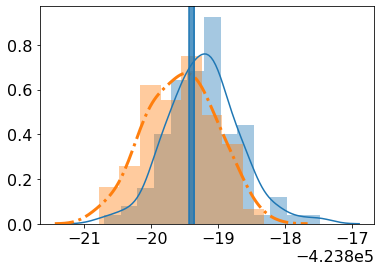

In [5]:
sns.distplot(forward_array)
sns.distplot(backward_array, kde_kws = {'ls': '-.', 'linewidth': 3})
dg_forward, ddg_forward = EXP(forward_array)
dg_backward, ddg_backward = EXP(-backward_array)
print(dg_forward, -dg_backward)
dg_BAR, ddg_BAR = BAR(forward_array, -backward_array)
print(dg_BAR, ddg_BAR)
plt.axvline(dg_forward)
plt.axvline(-dg_backward)
plt.axvline(dg_BAR)
plt.axvline(dg_BAR + ddg_BAR)
plt.axvline(dg_BAR - ddg_BAR)

alright, so we have generated all of the free energy corrections...can we plot them?


we many need to remove those that are greater than abs(10) kT since these correspond to works for which only one phase was computed

/home/dominic/.local/lib/python3.6/site-packages/numpy-1.17.2-py3.6-linux-x86_64.egg/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


zero-size array to reduction operation maximum which has no identity
min() arg is an empty sequence


/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

zero-size array to reduction operation maximum which has no identity
min() arg is an empty sequence


/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

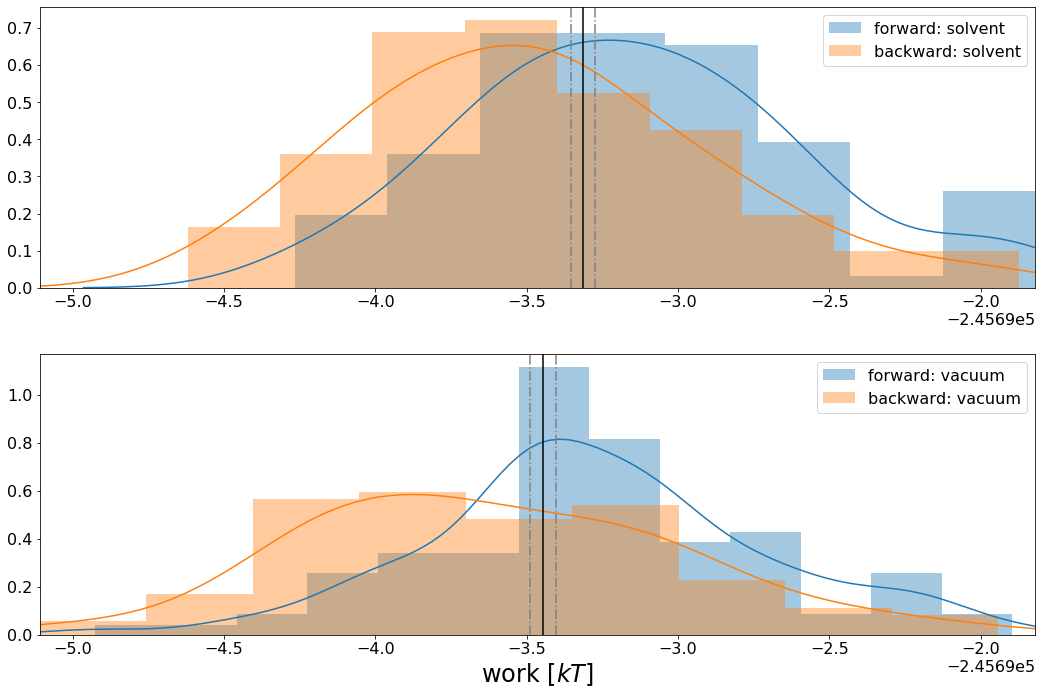

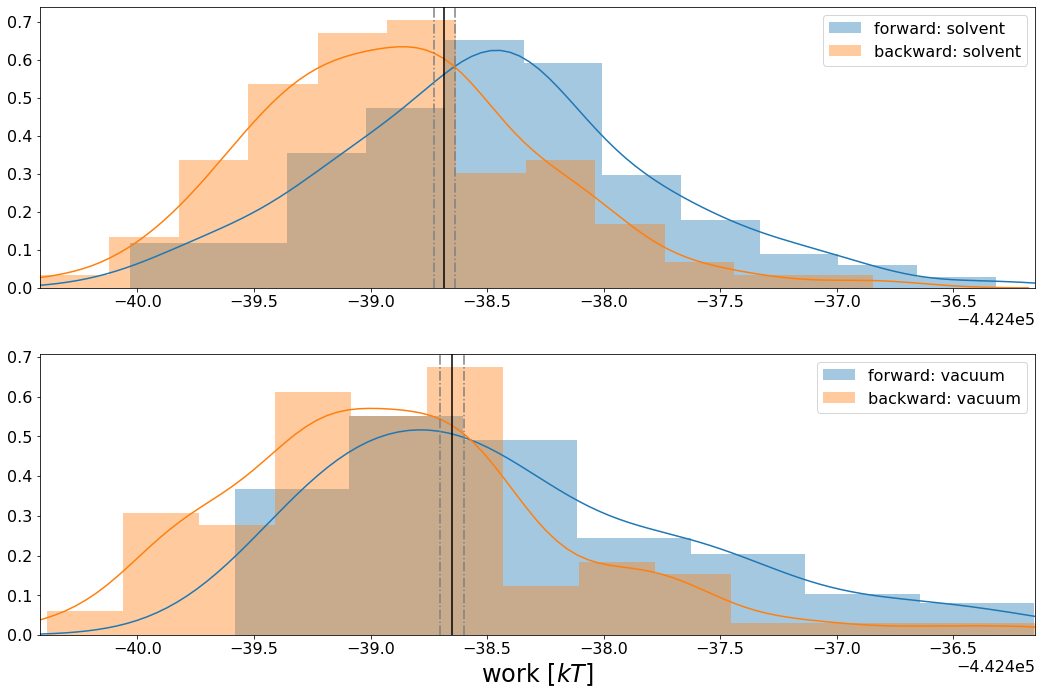

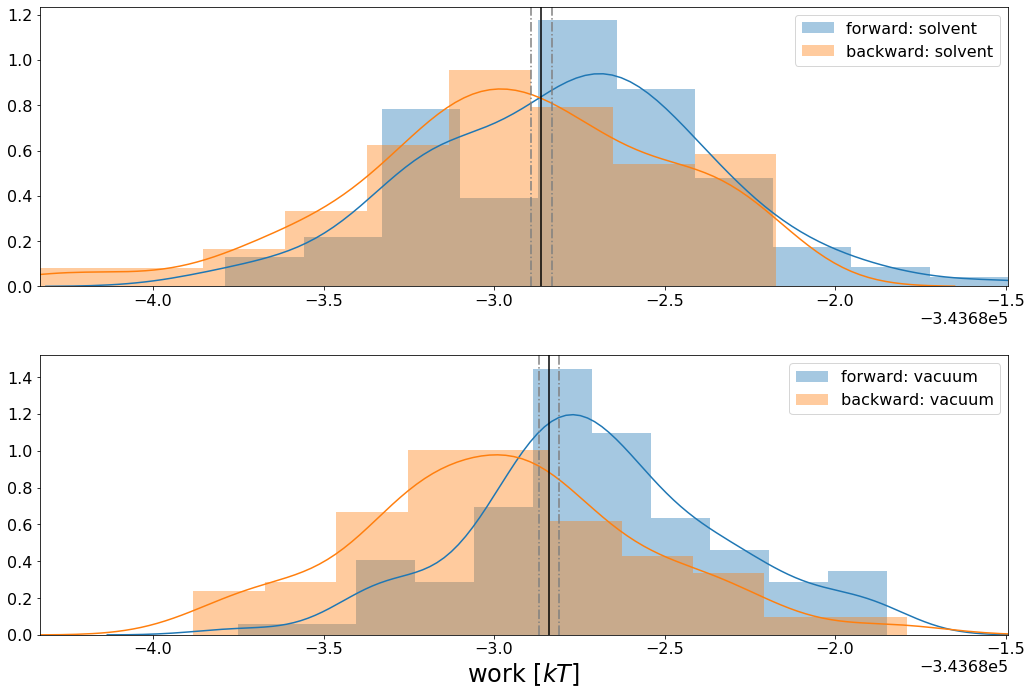

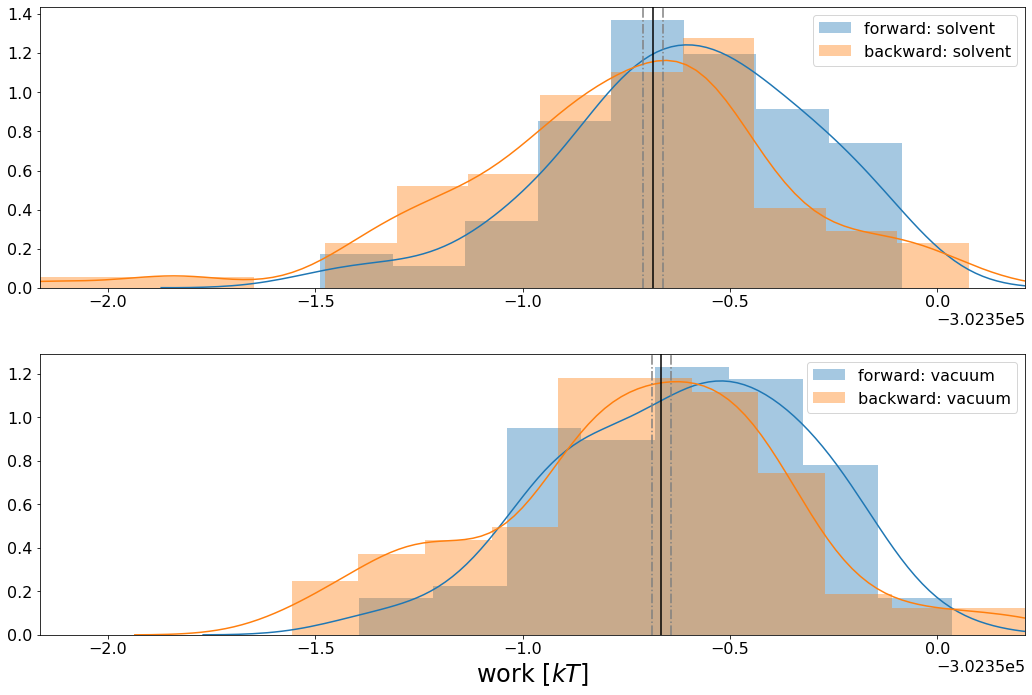

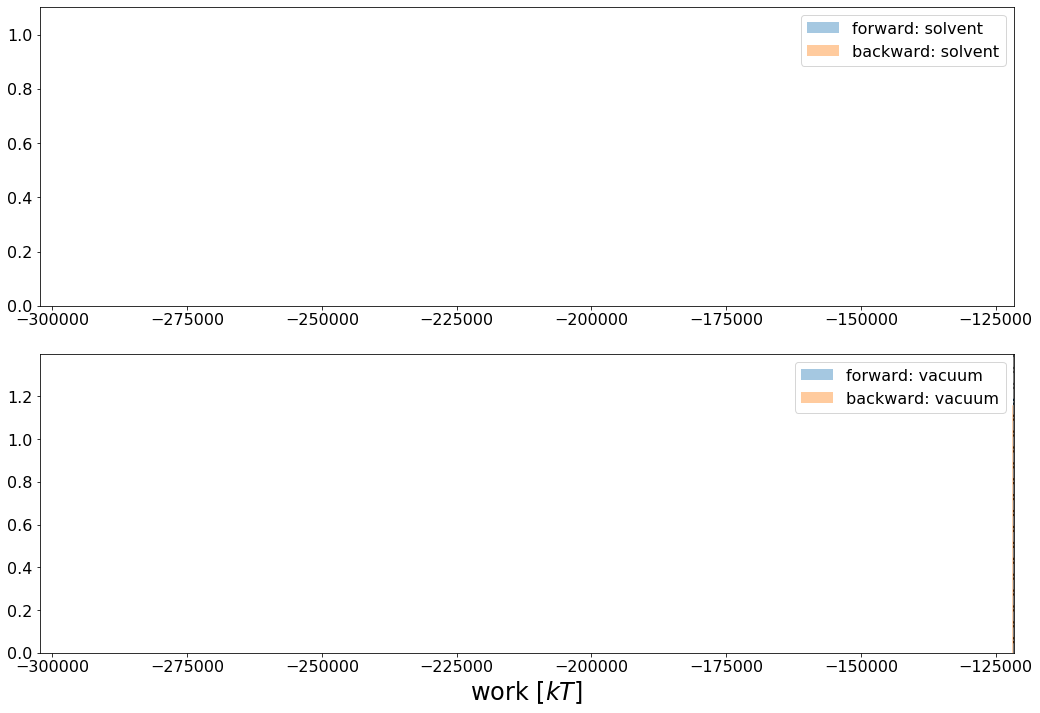

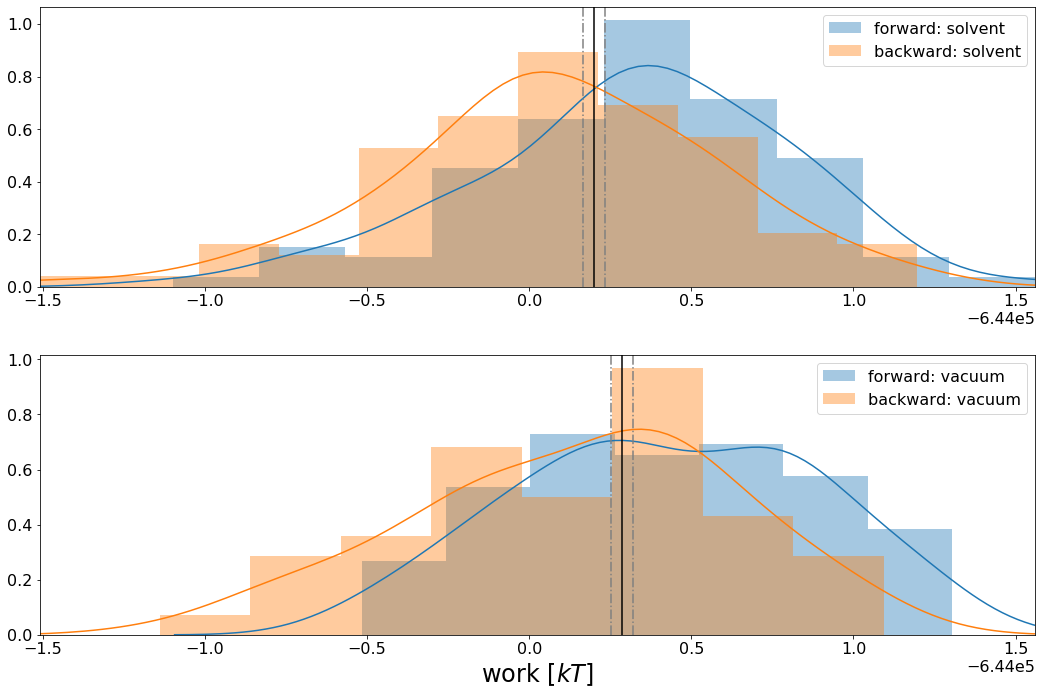

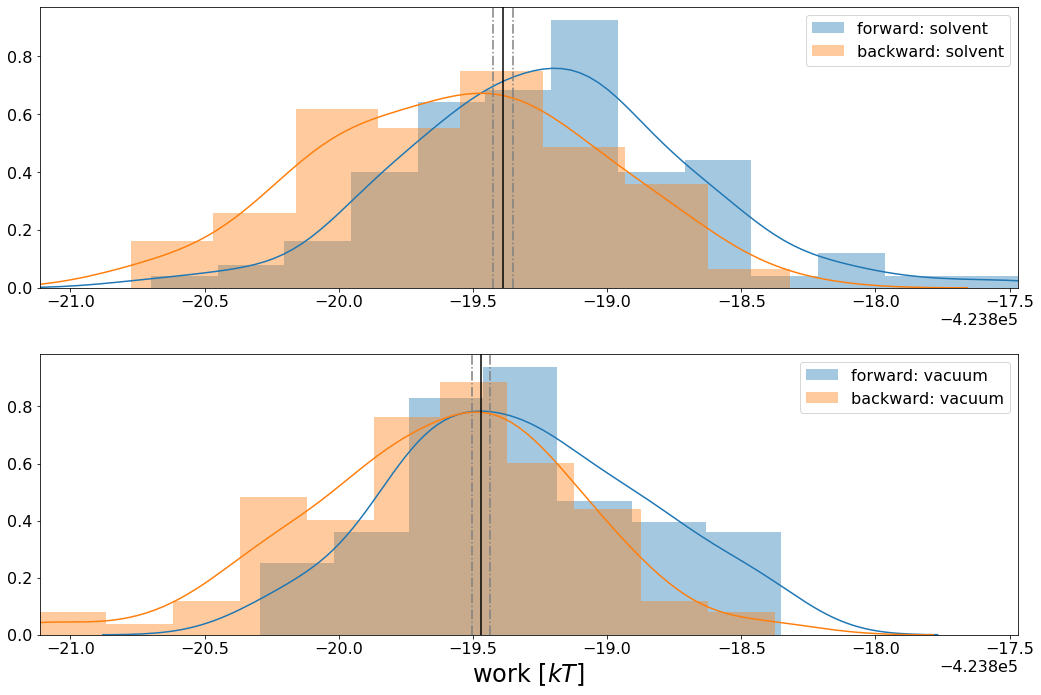

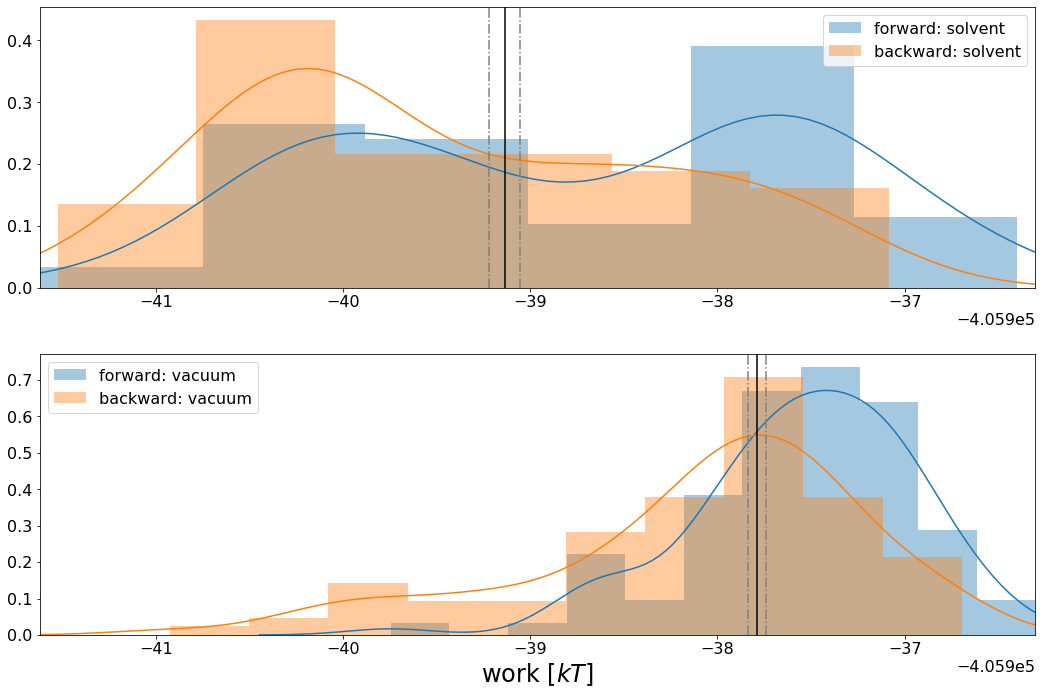

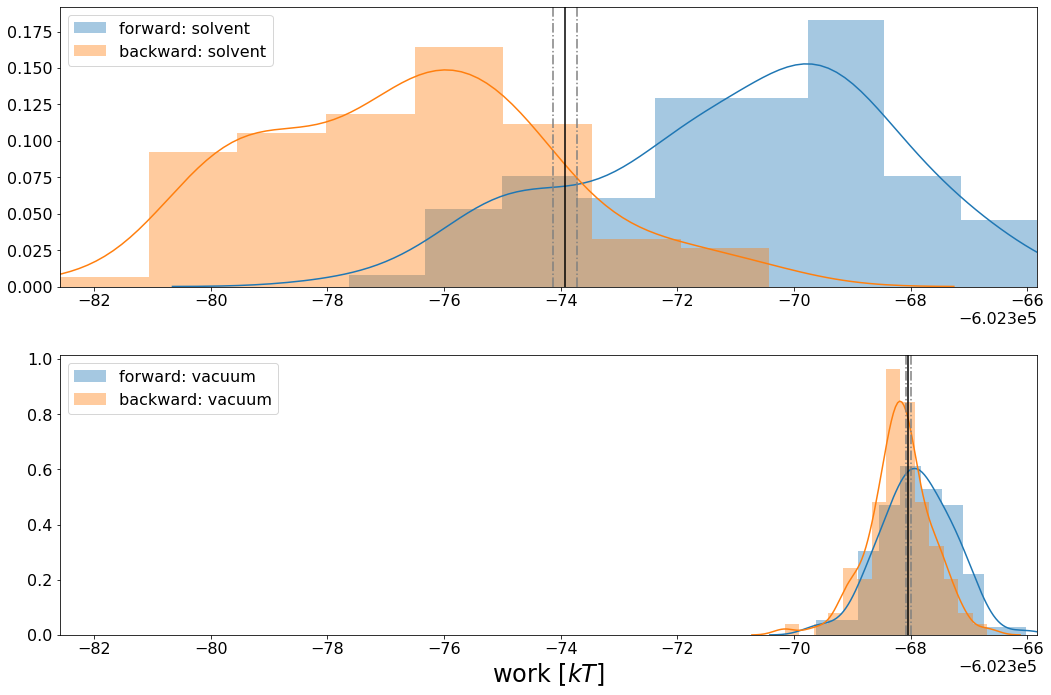

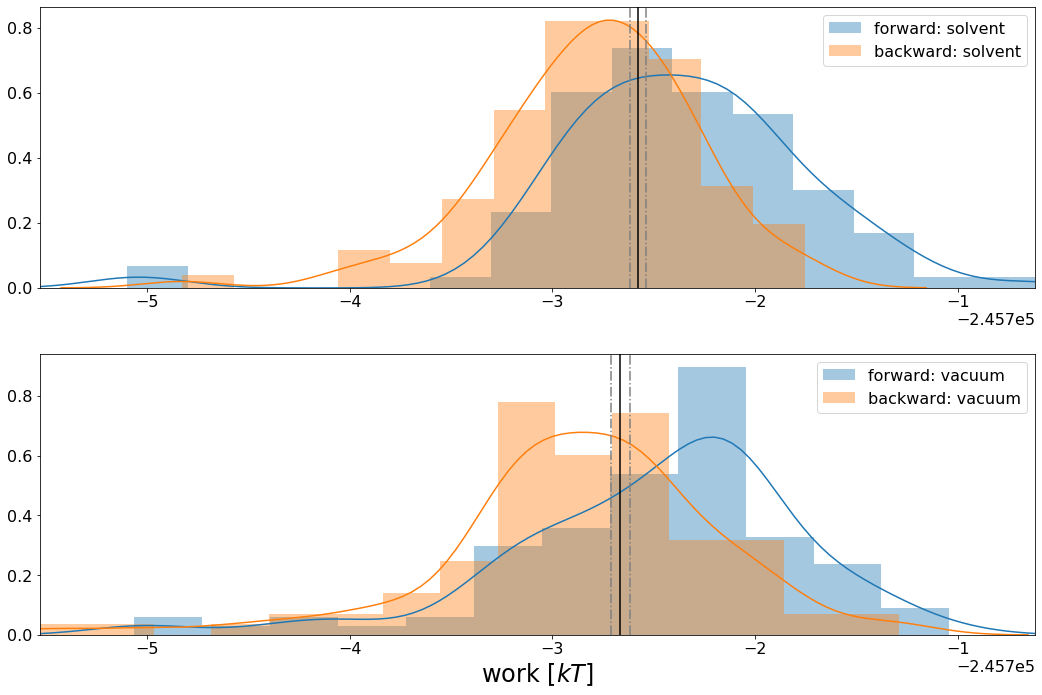

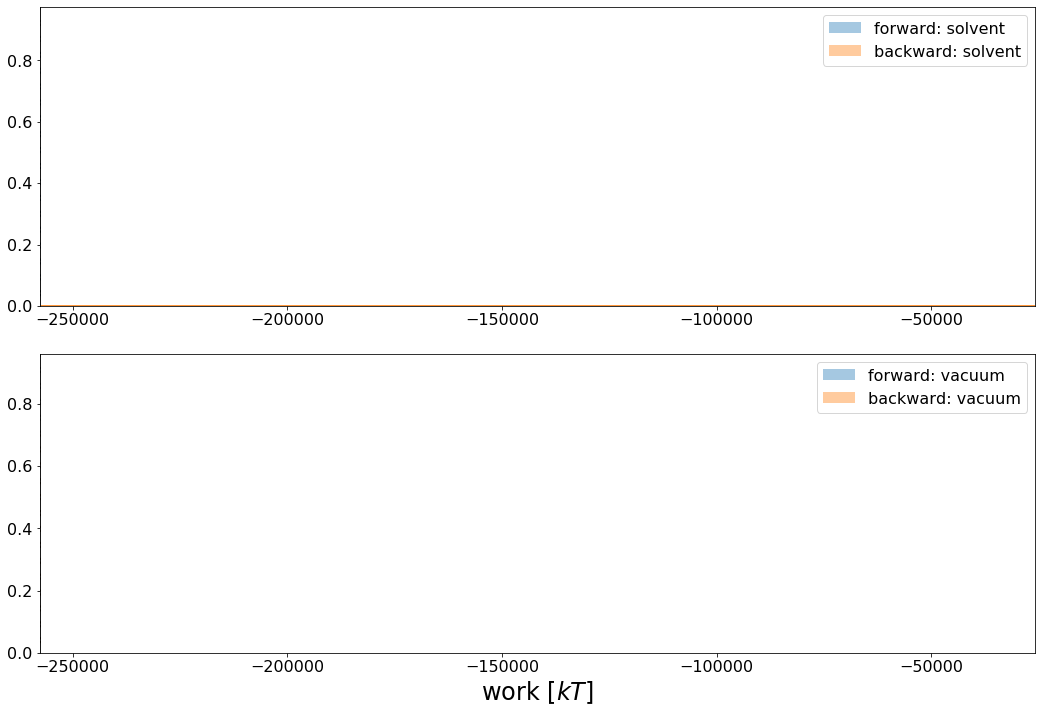

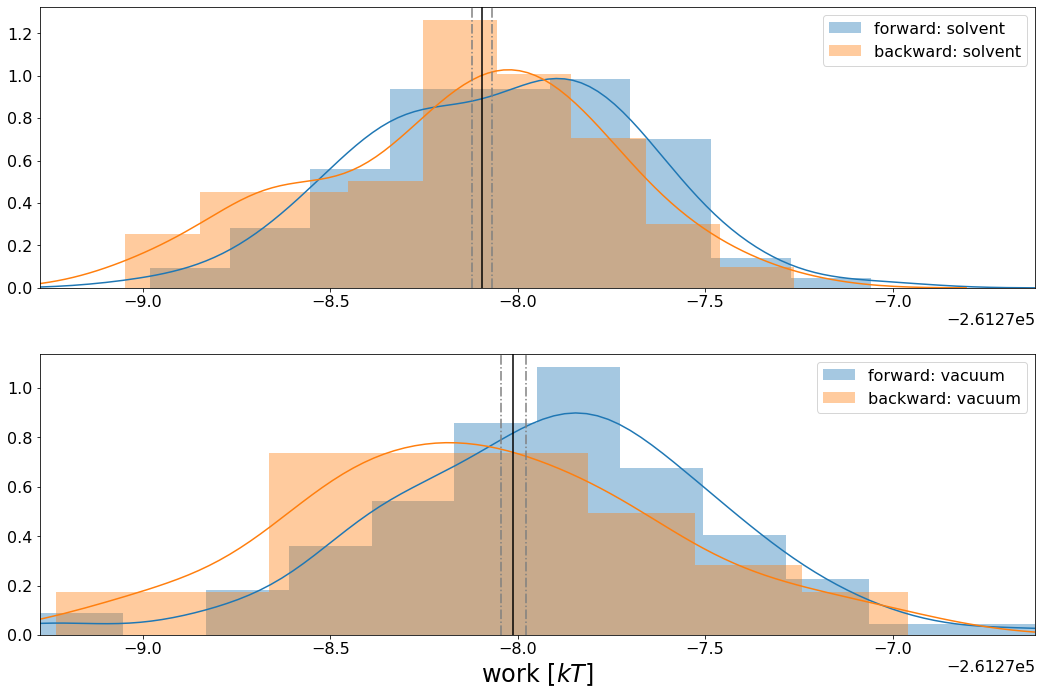

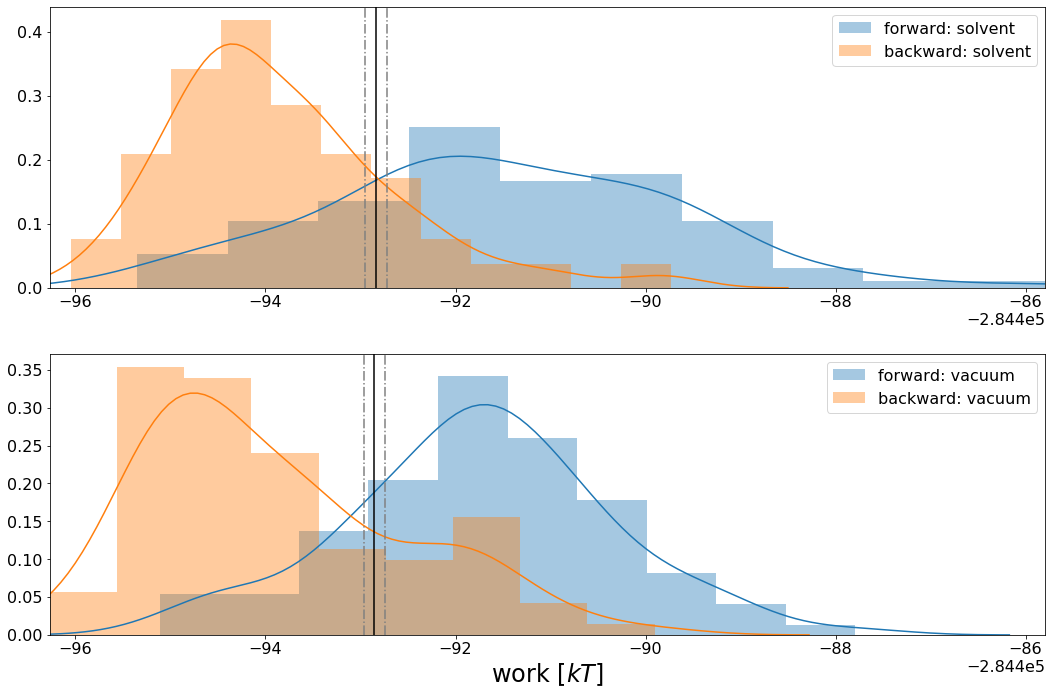

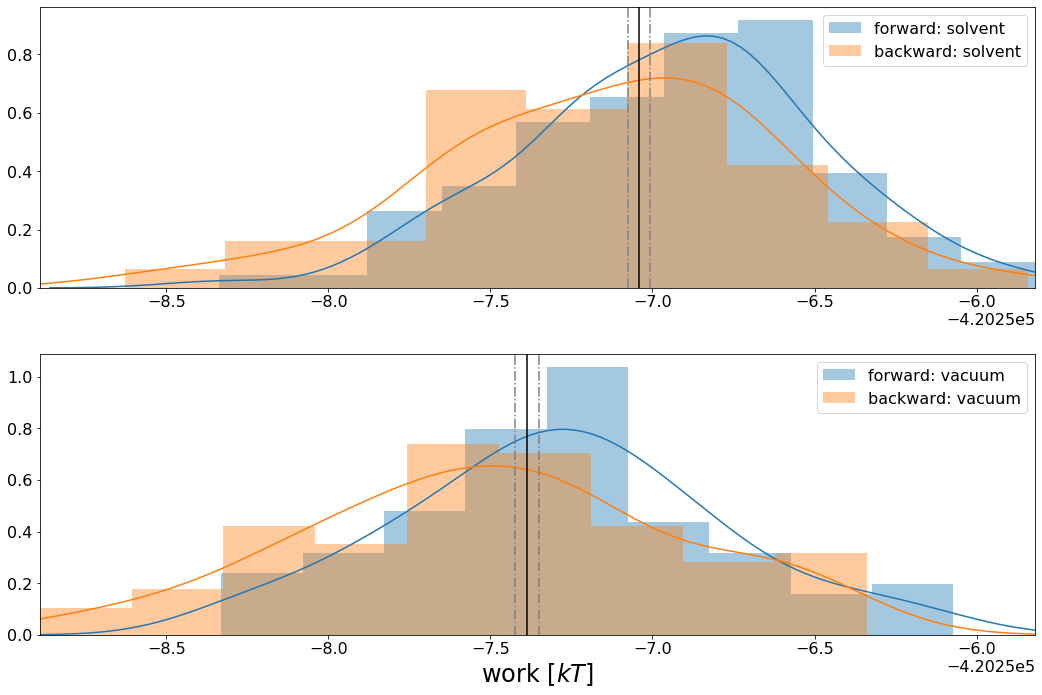

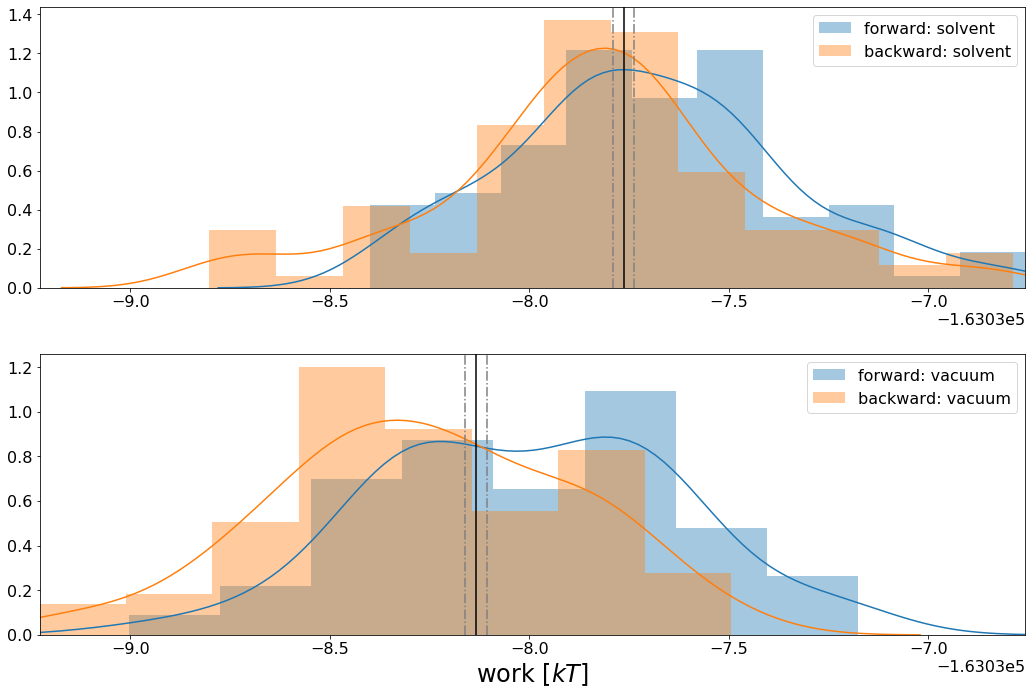

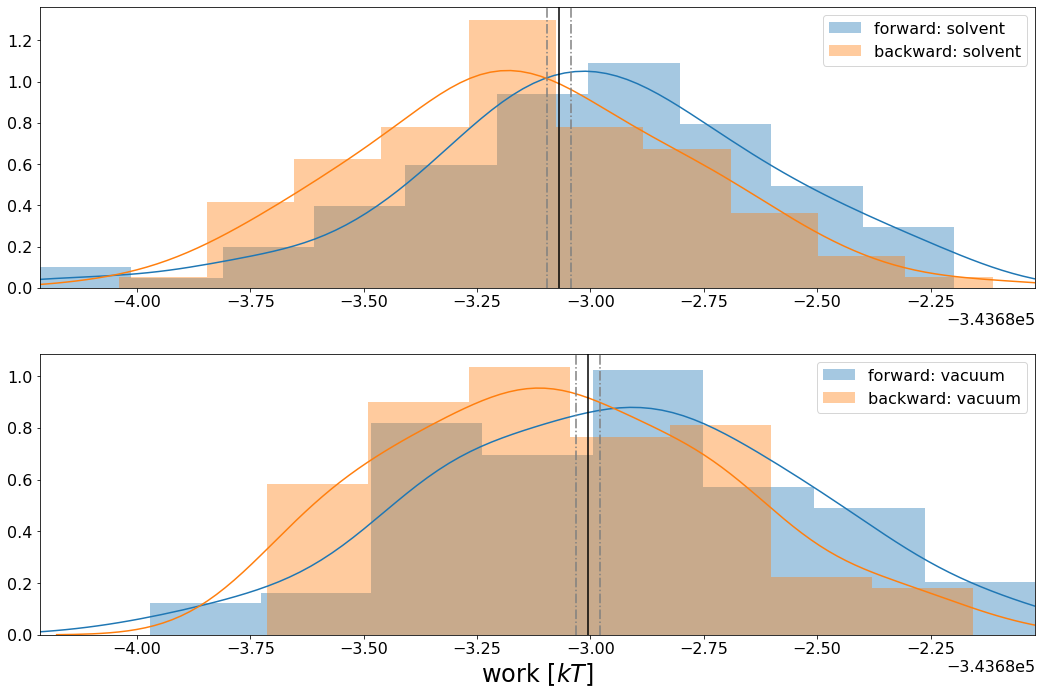

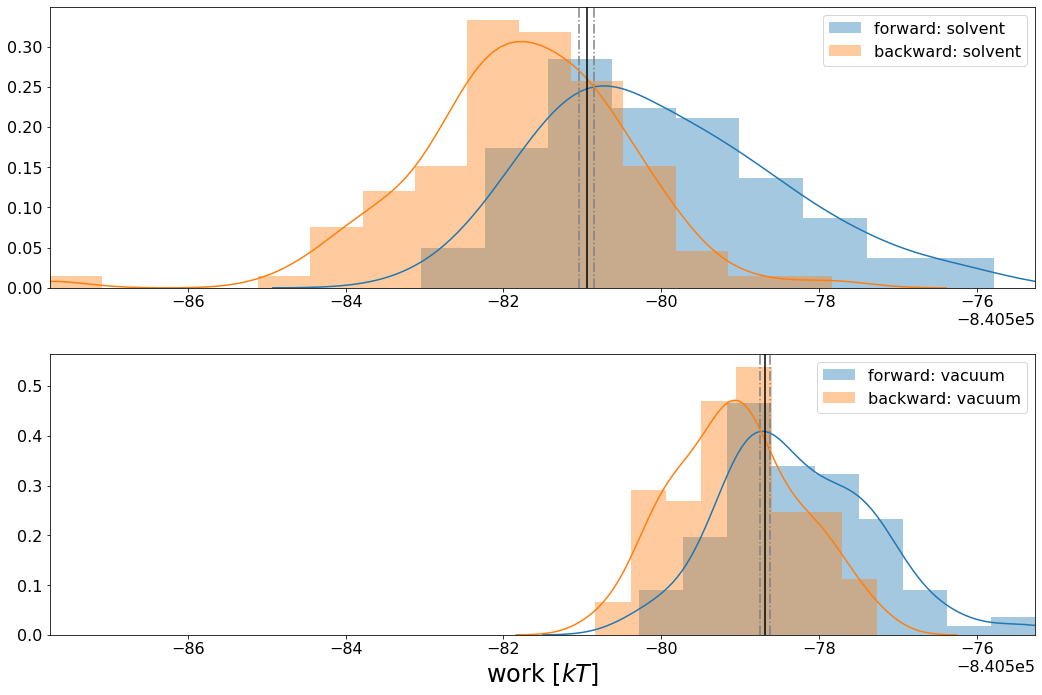

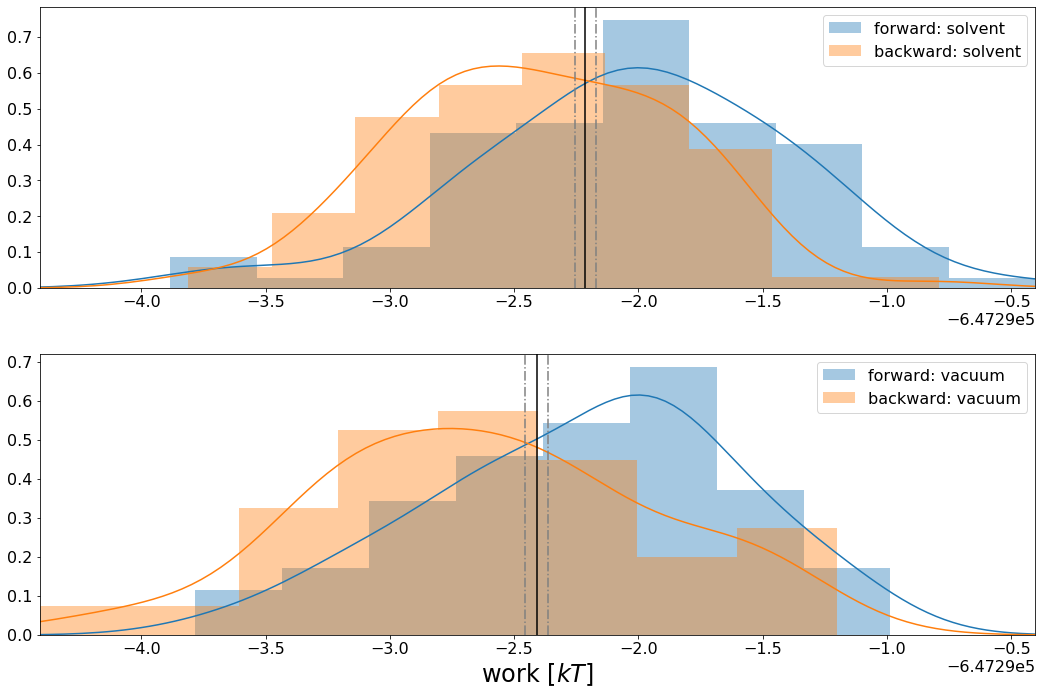

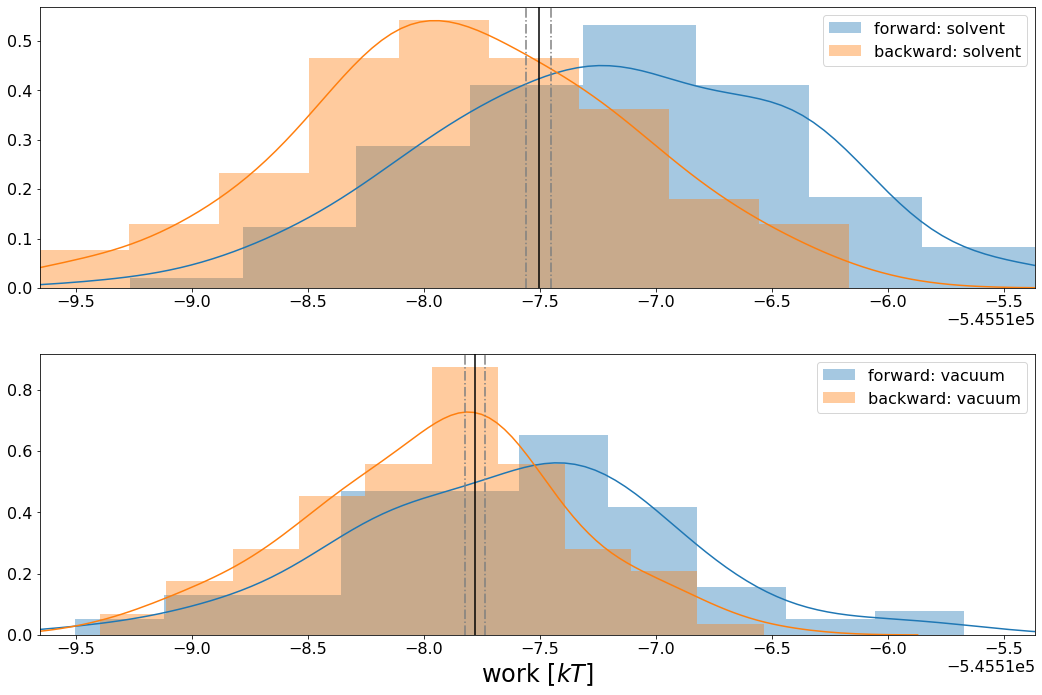

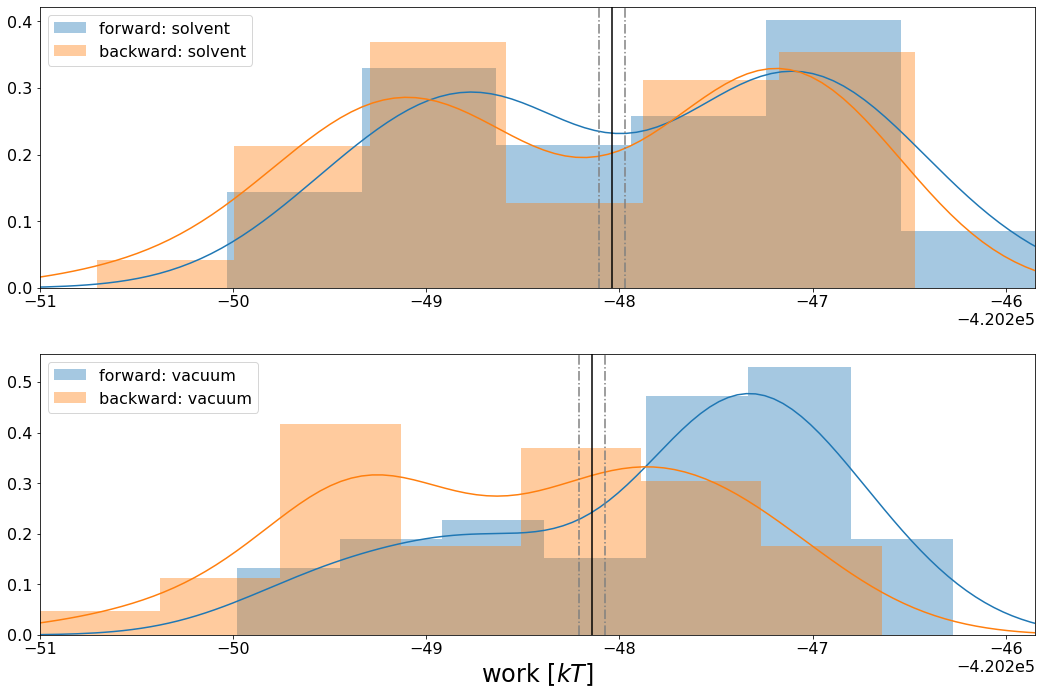

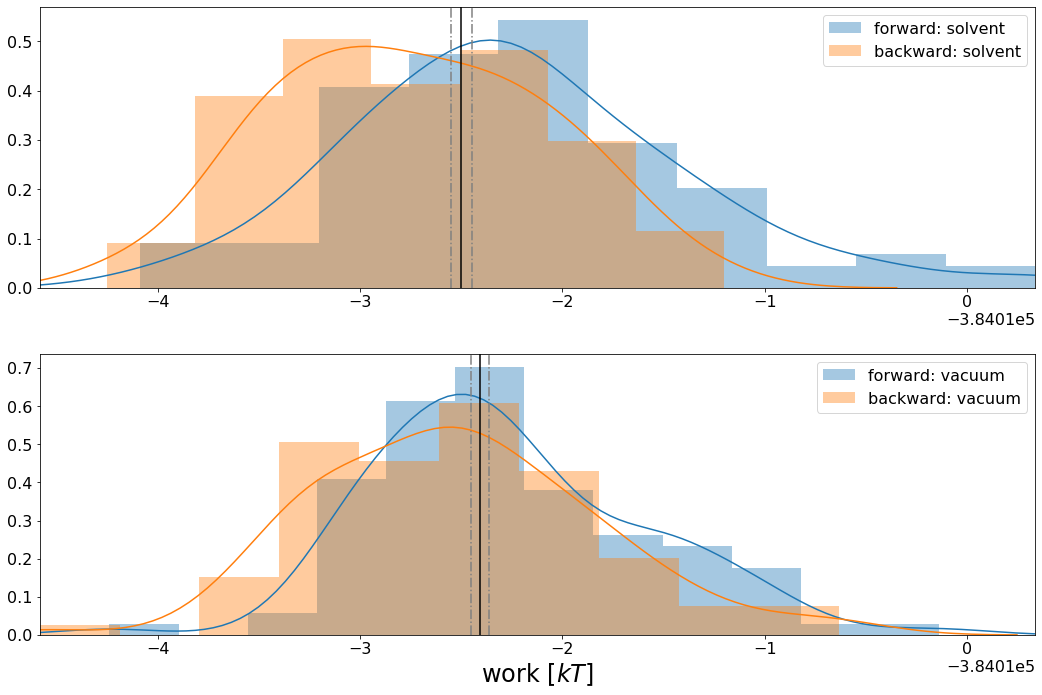

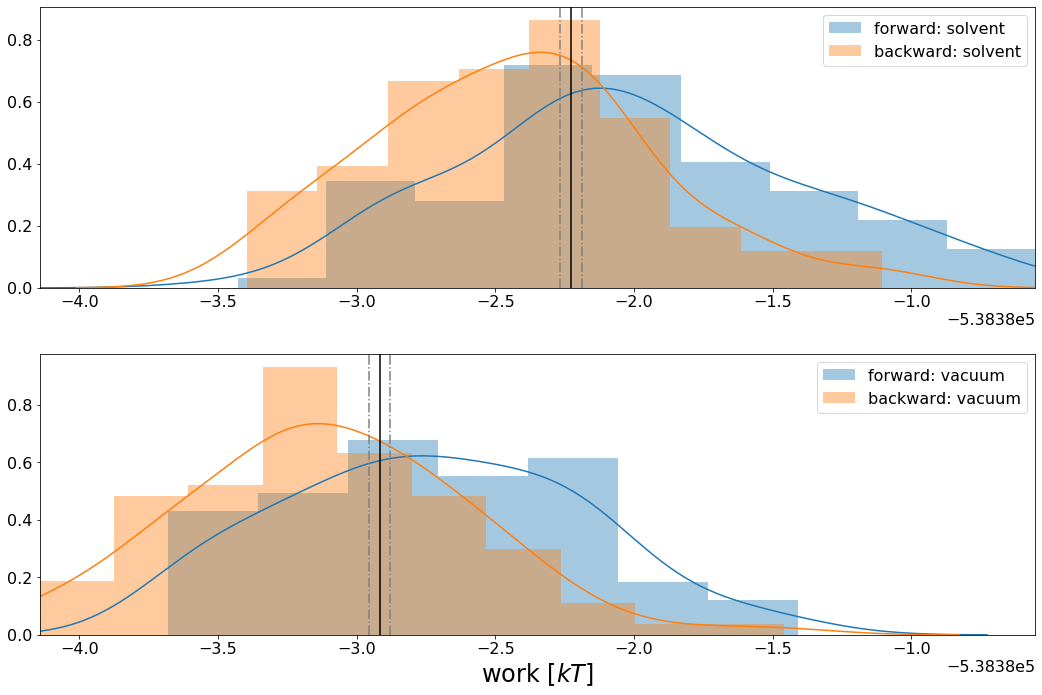

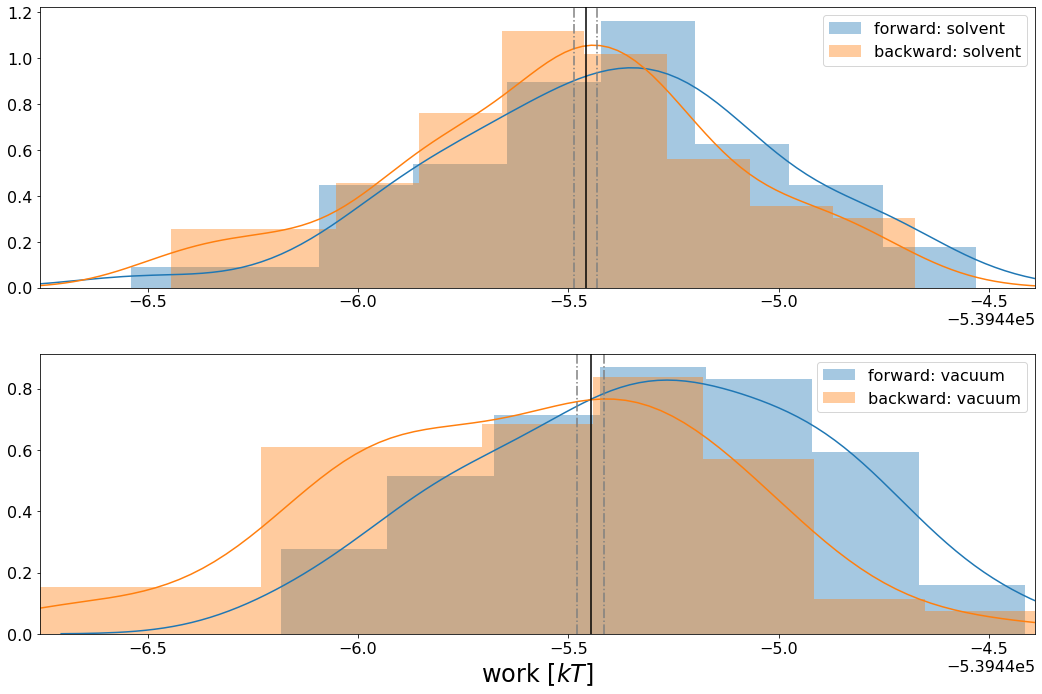

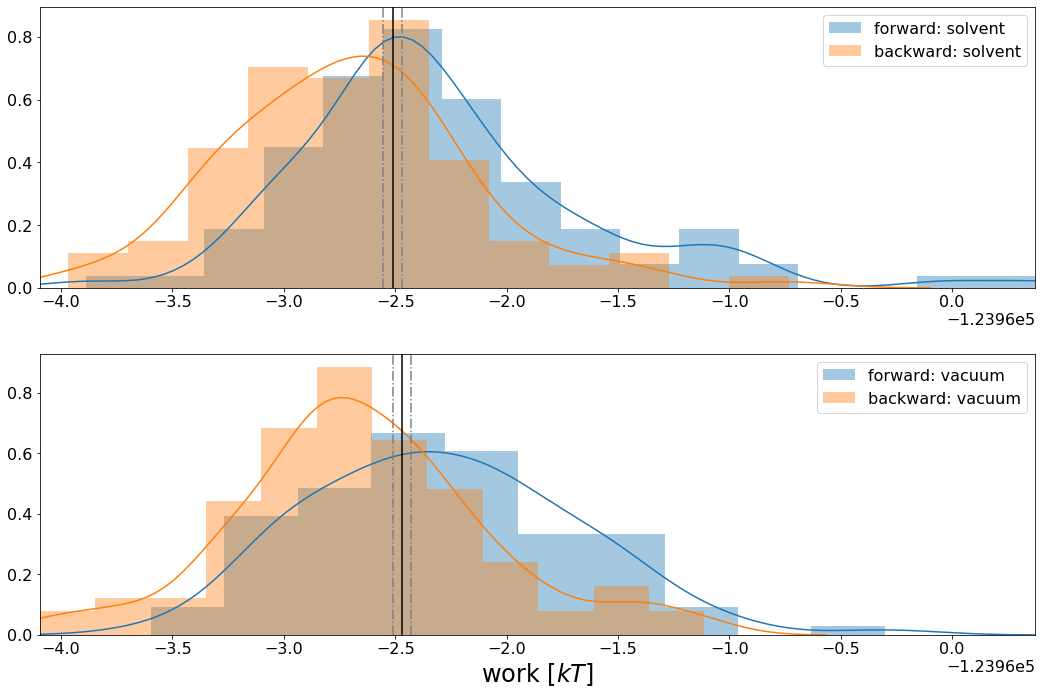

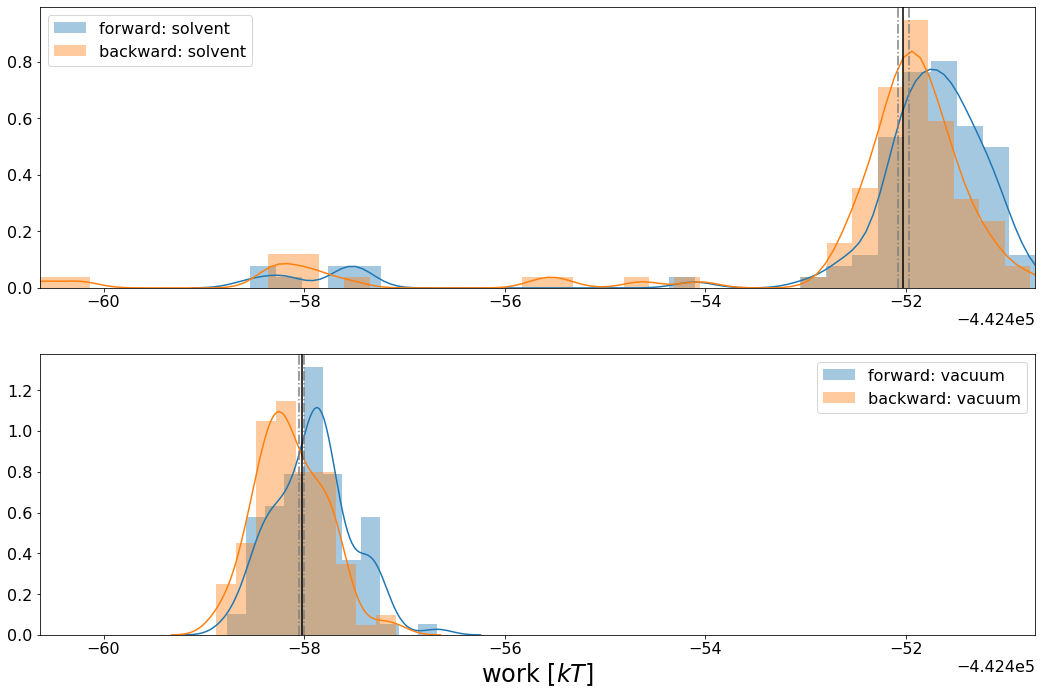

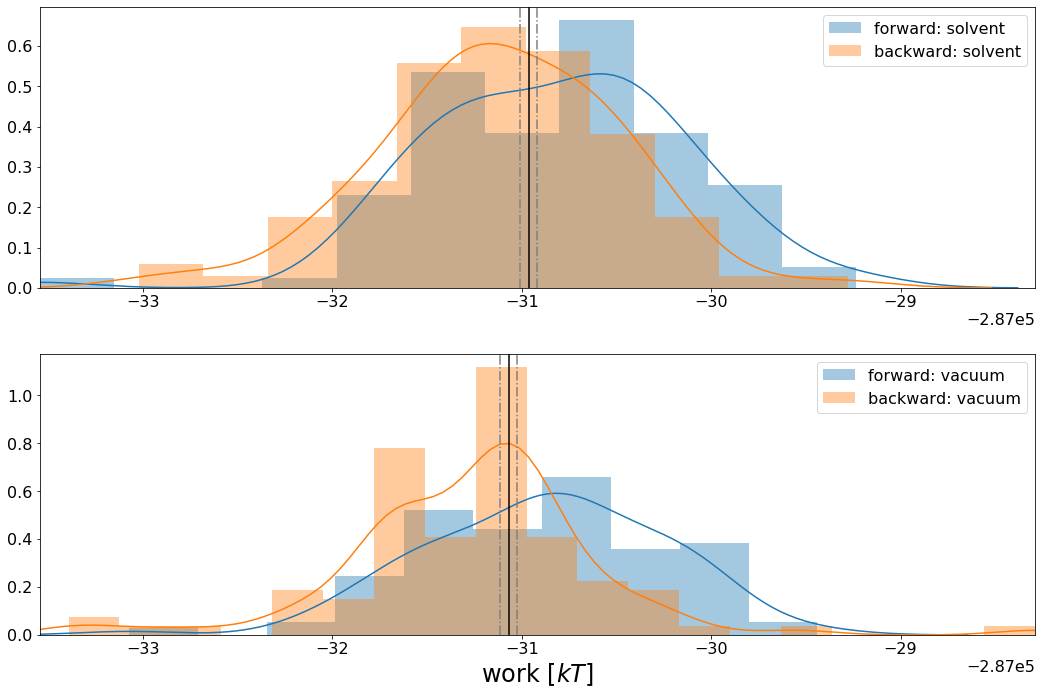

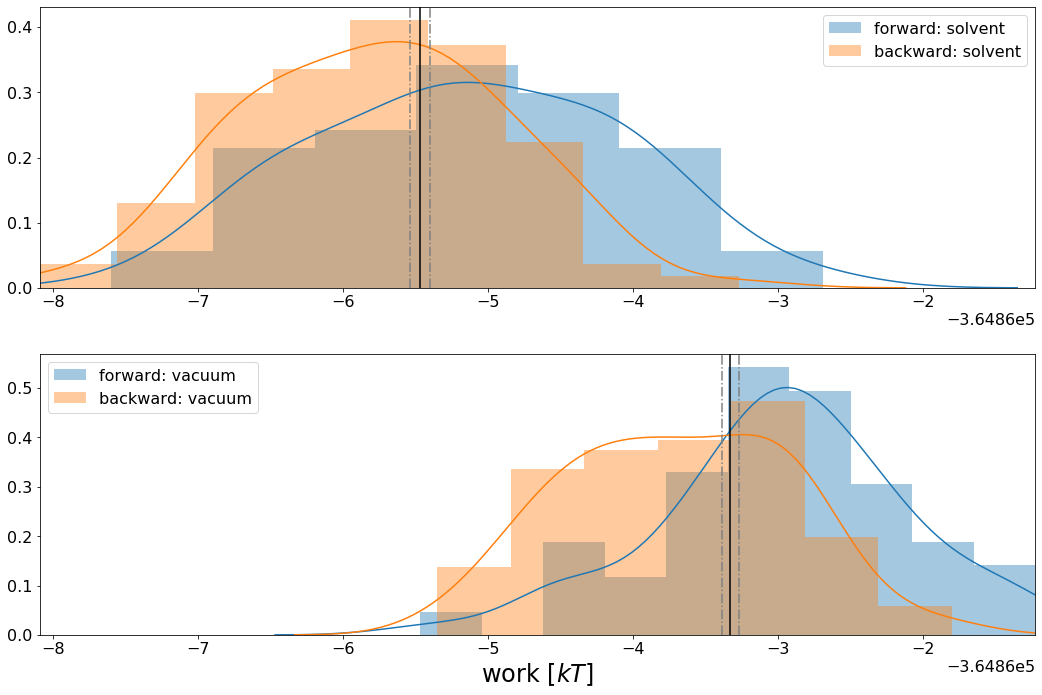

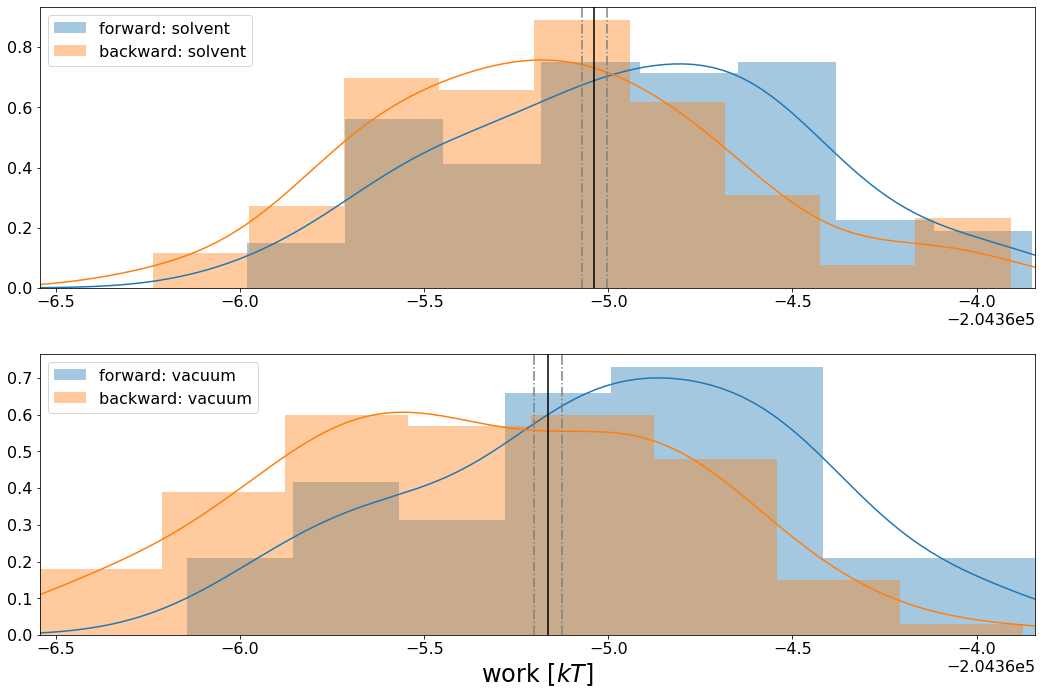

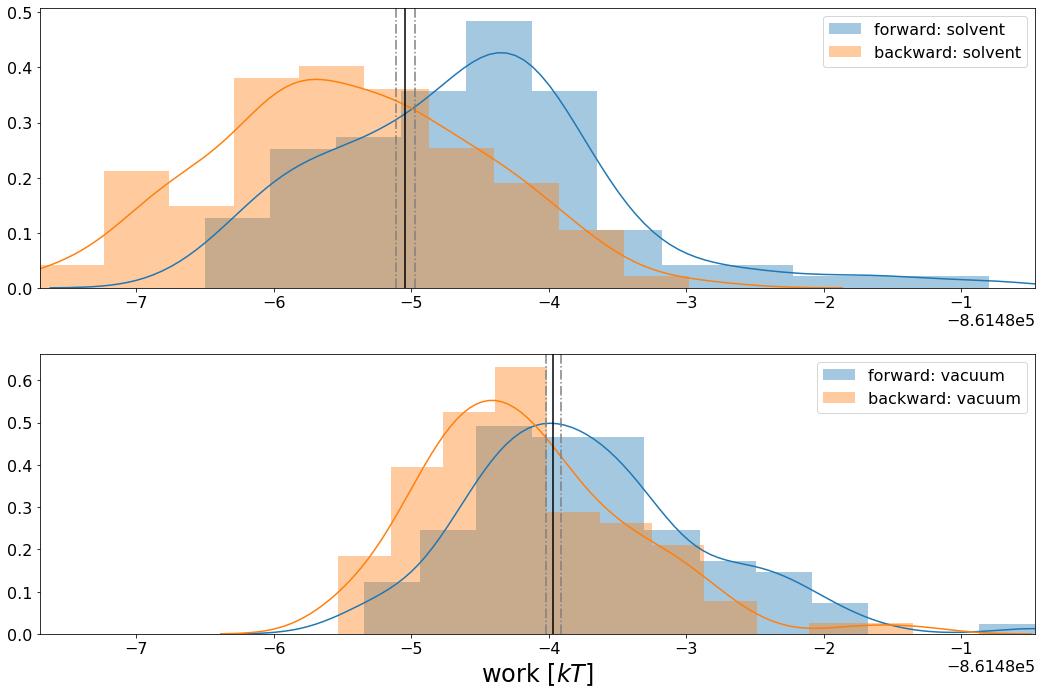

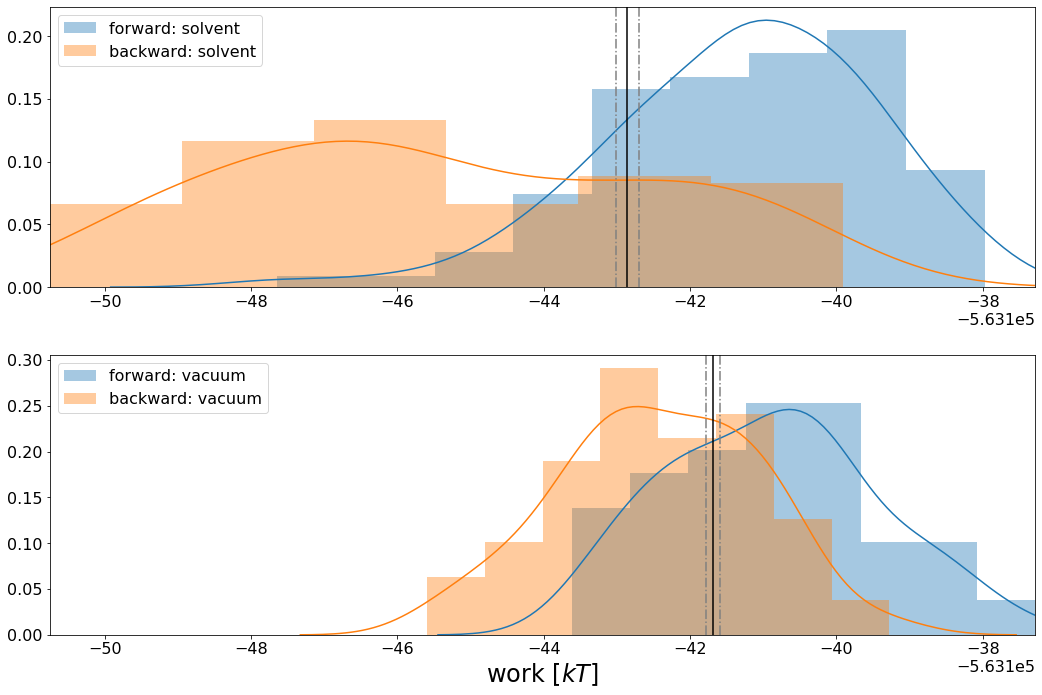

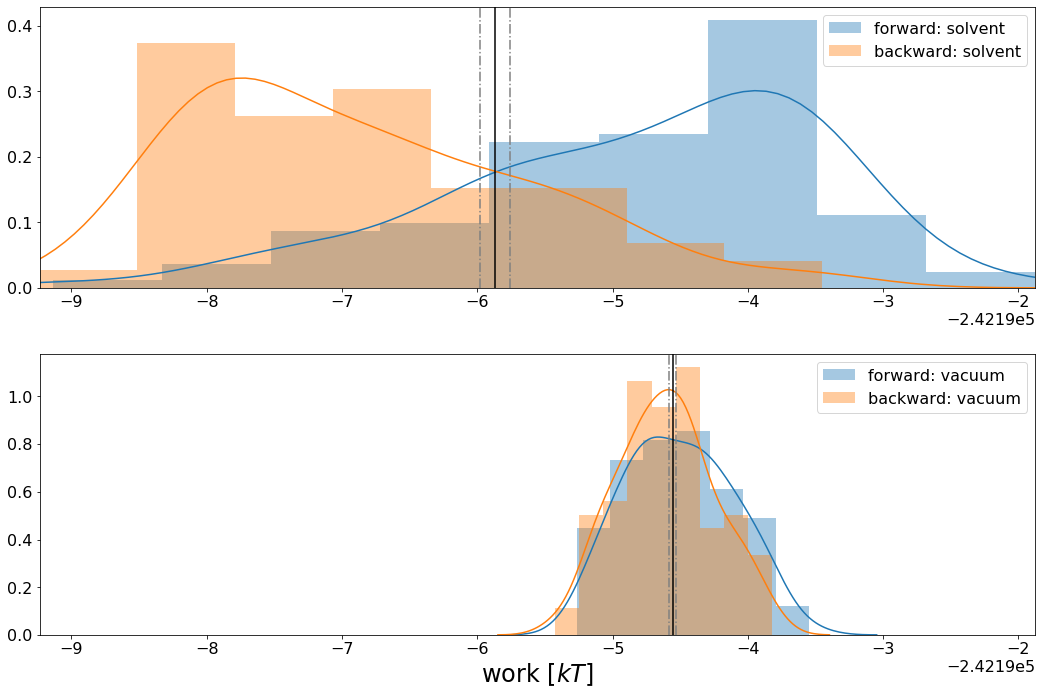

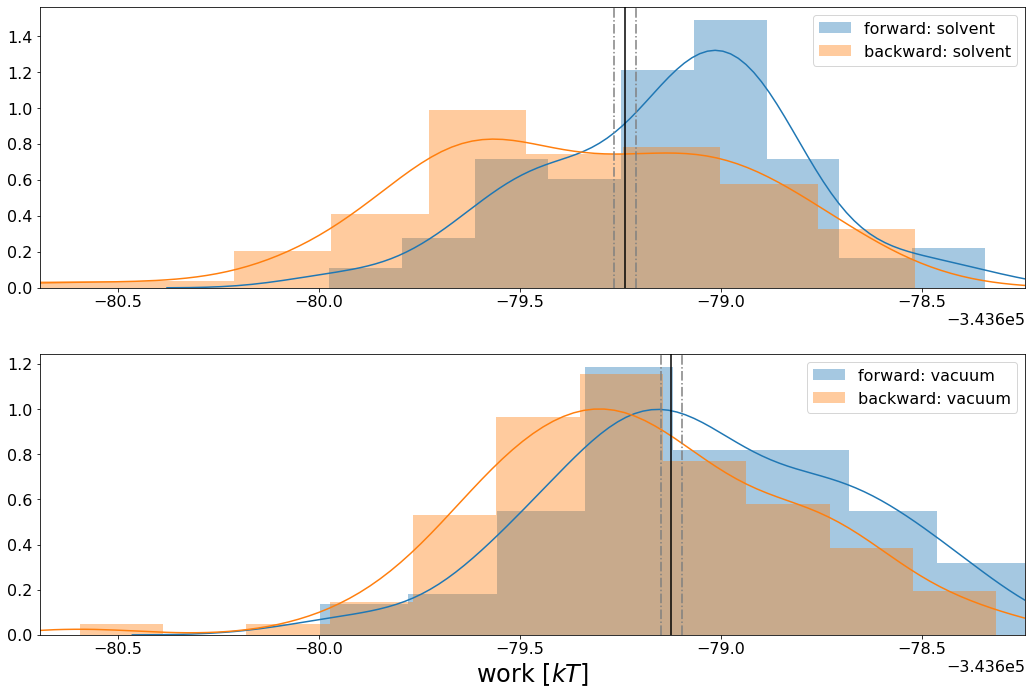

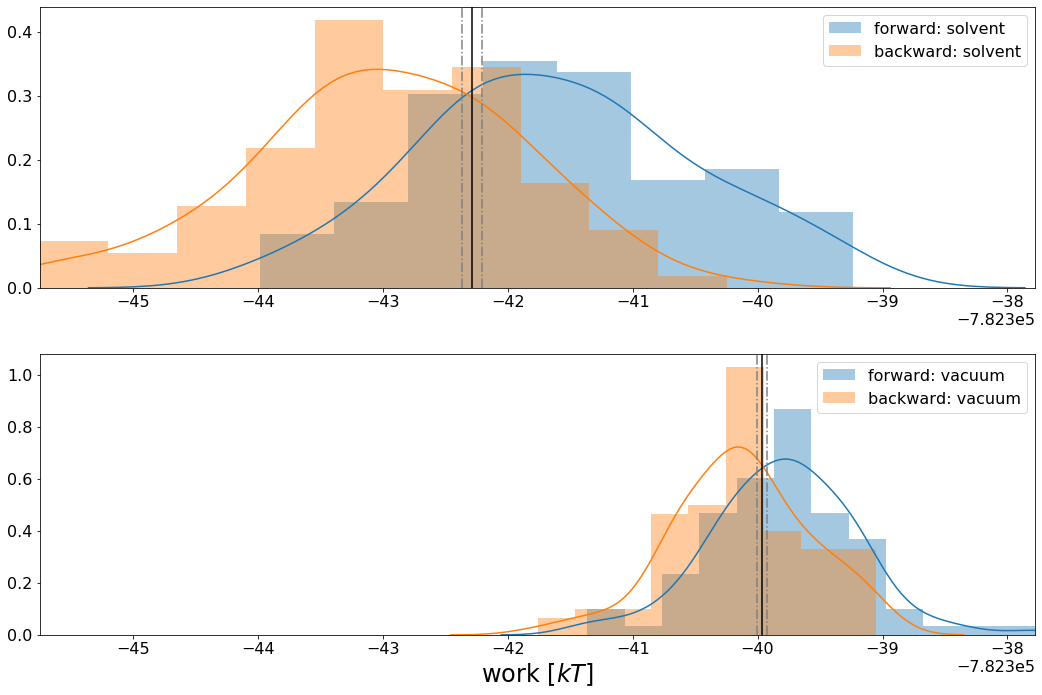

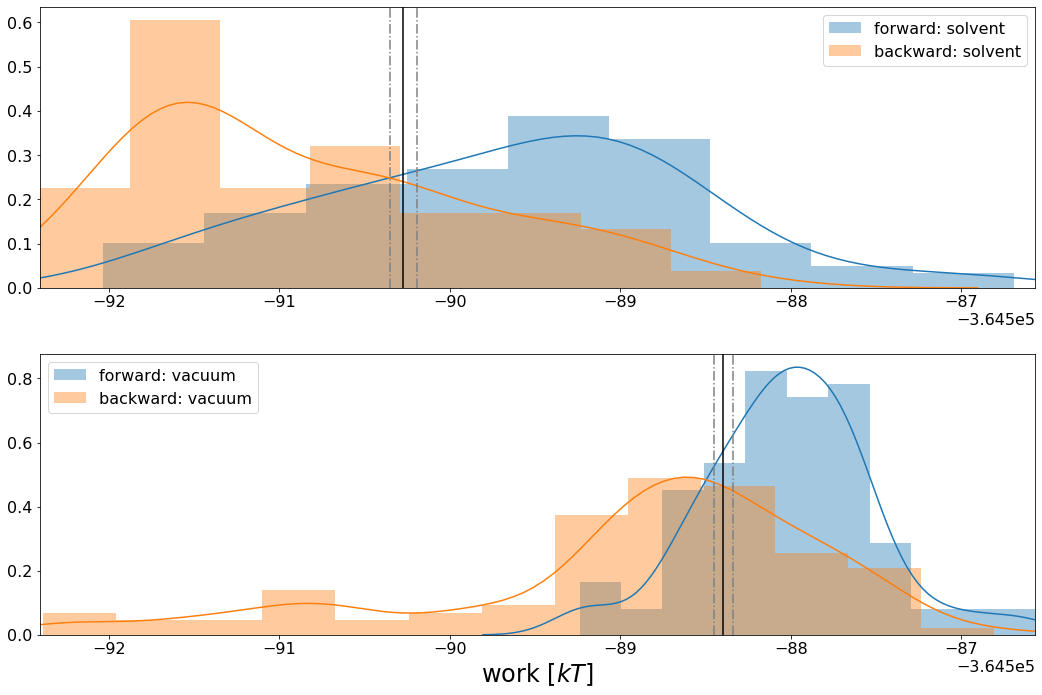

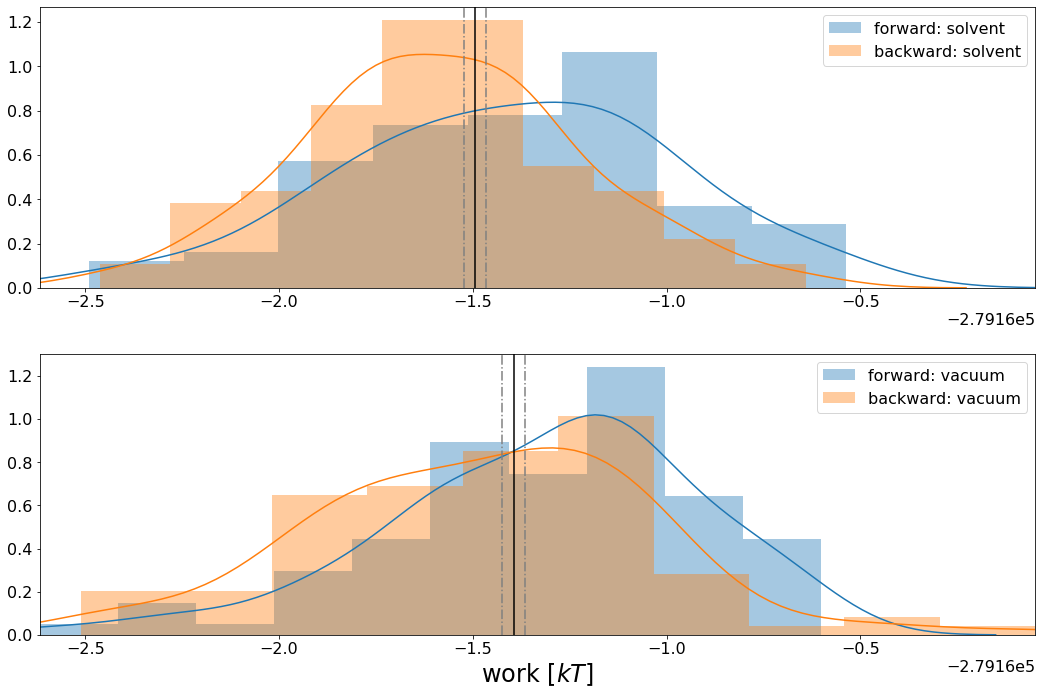

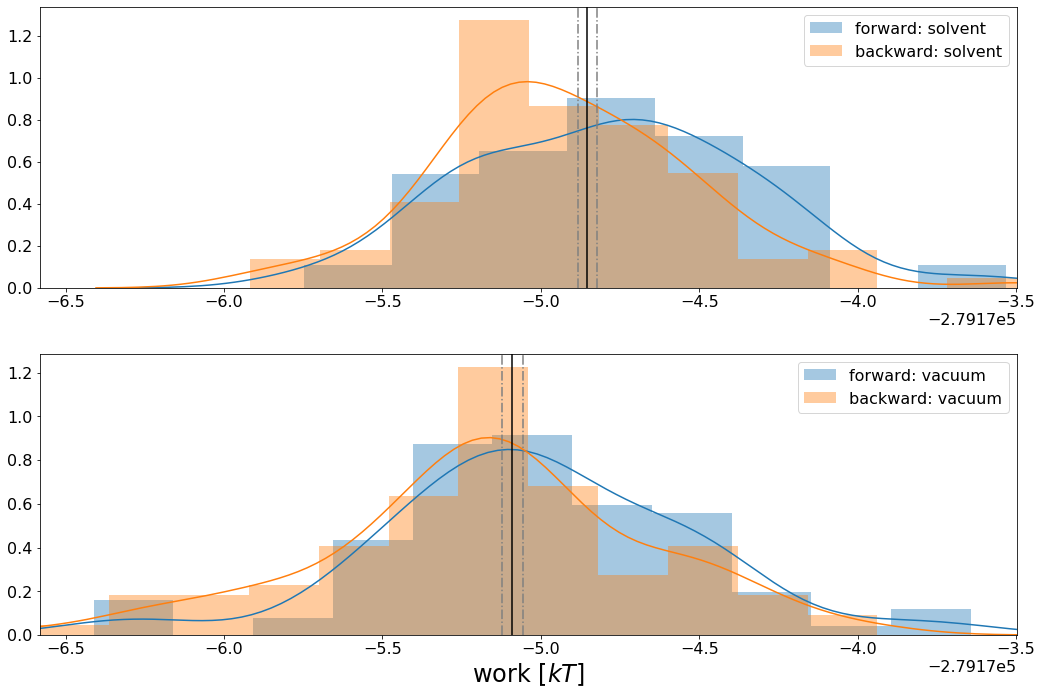

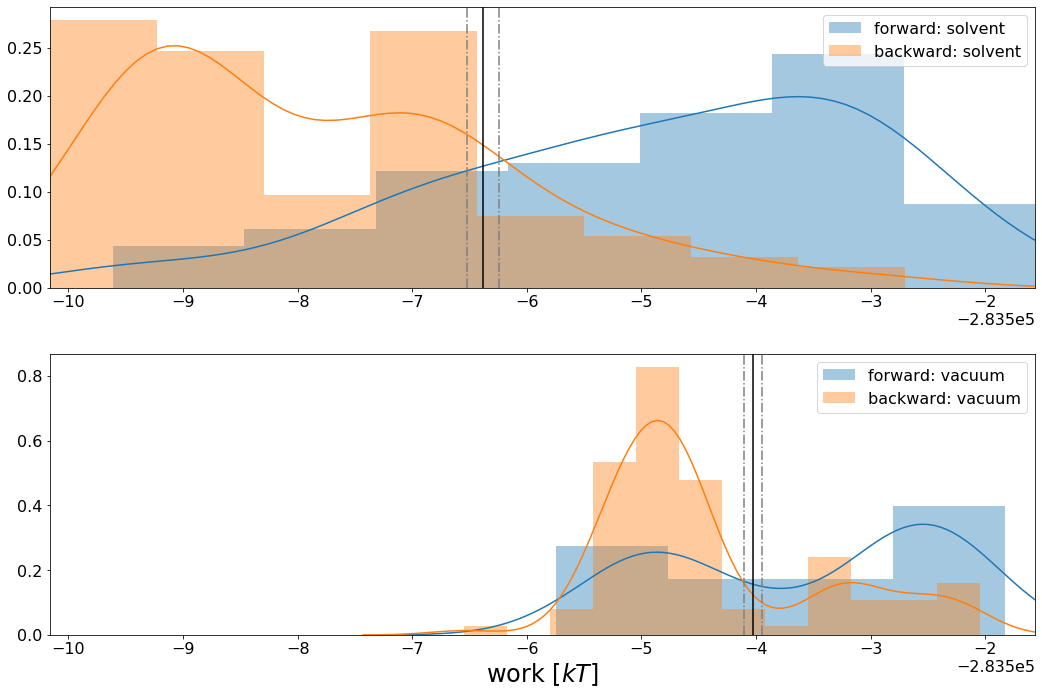

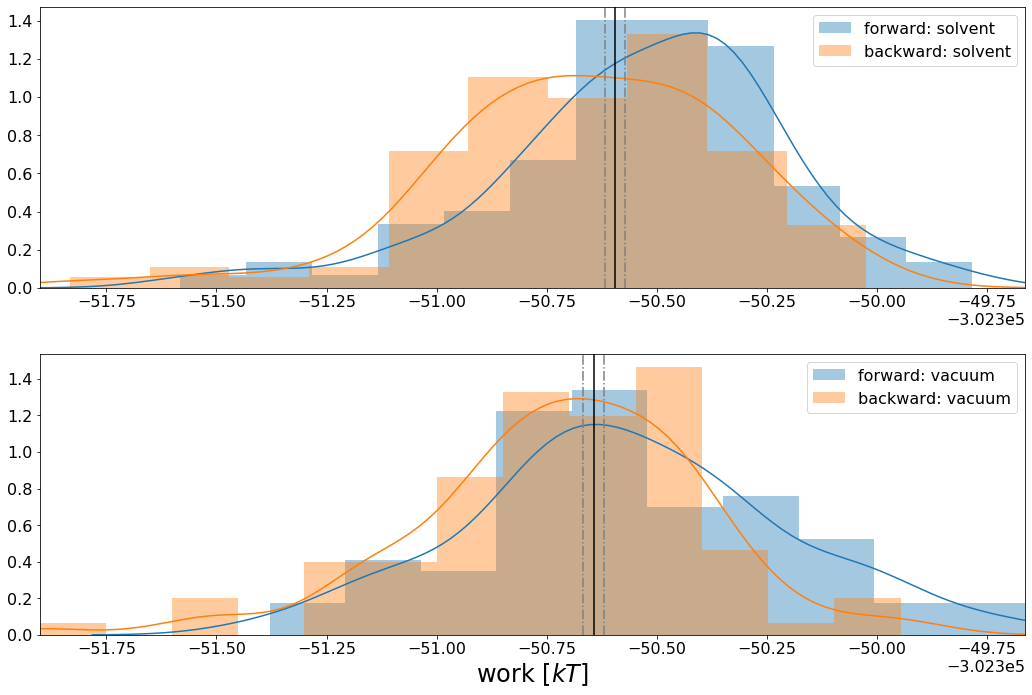

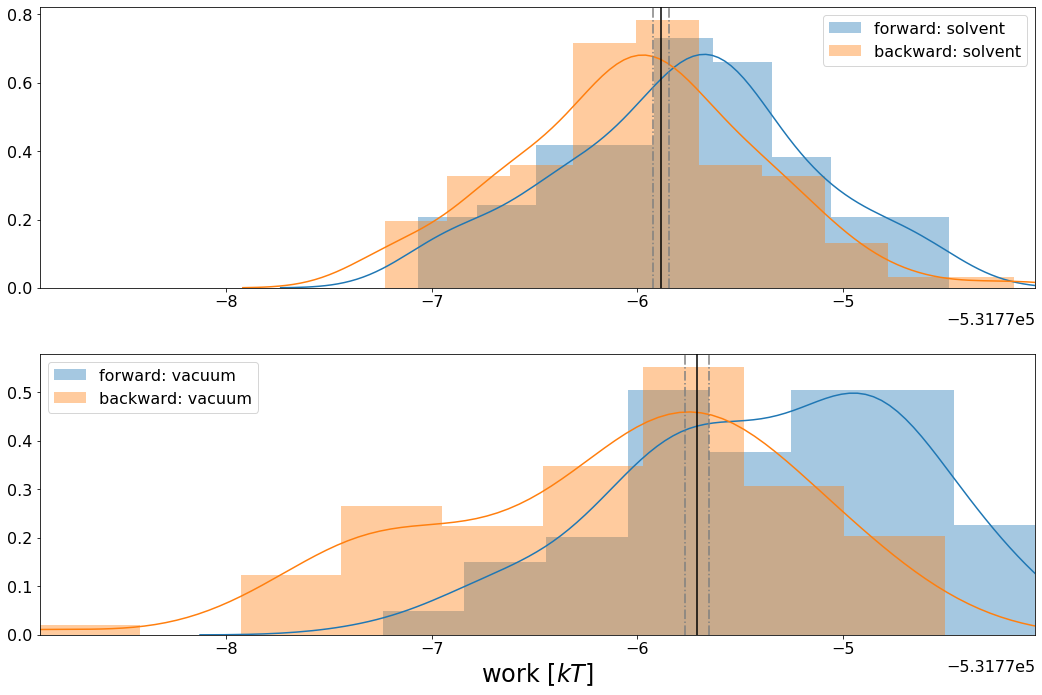

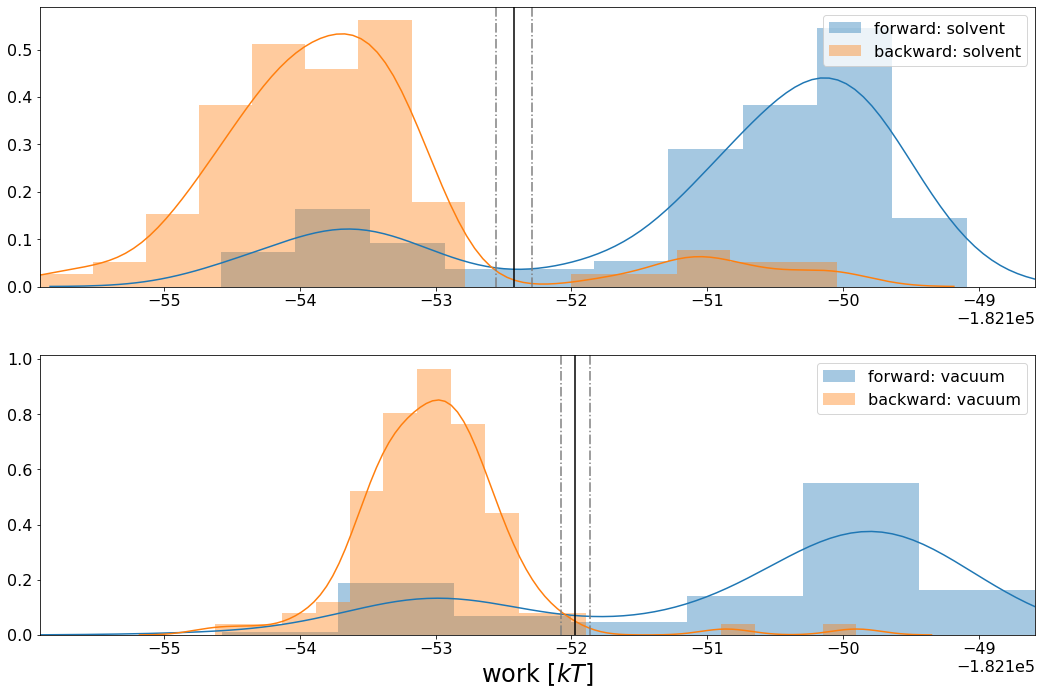

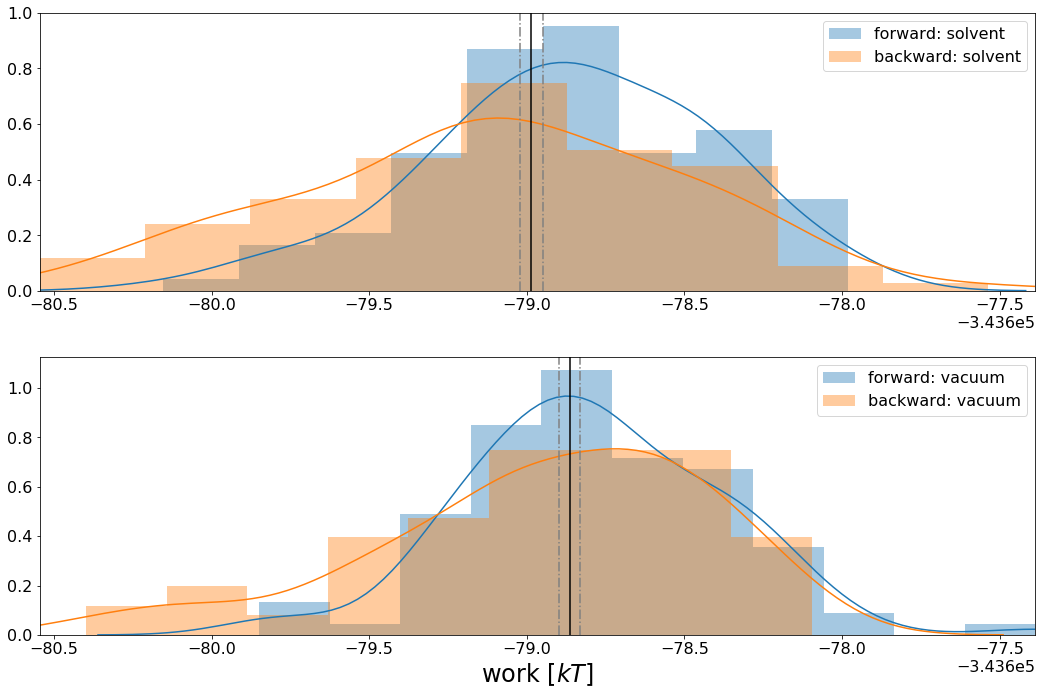

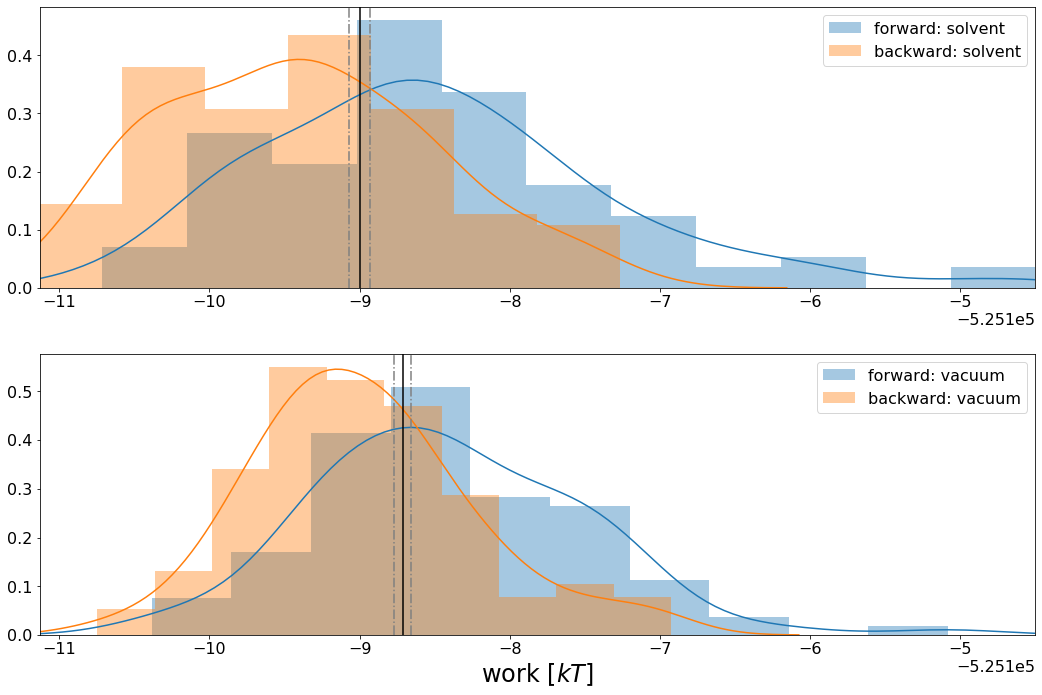

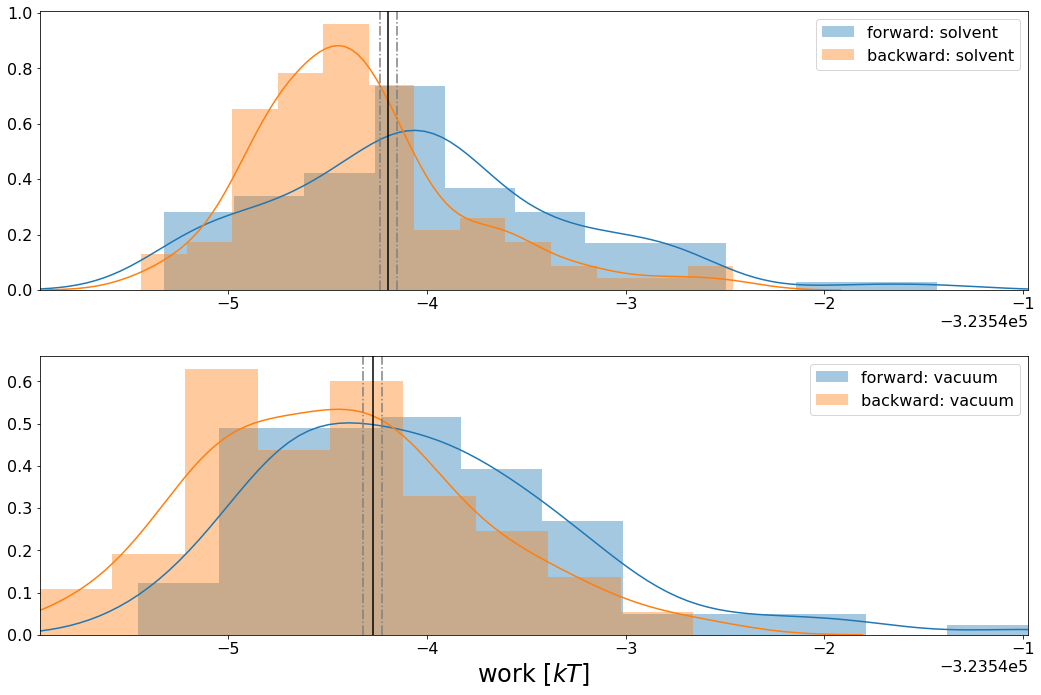

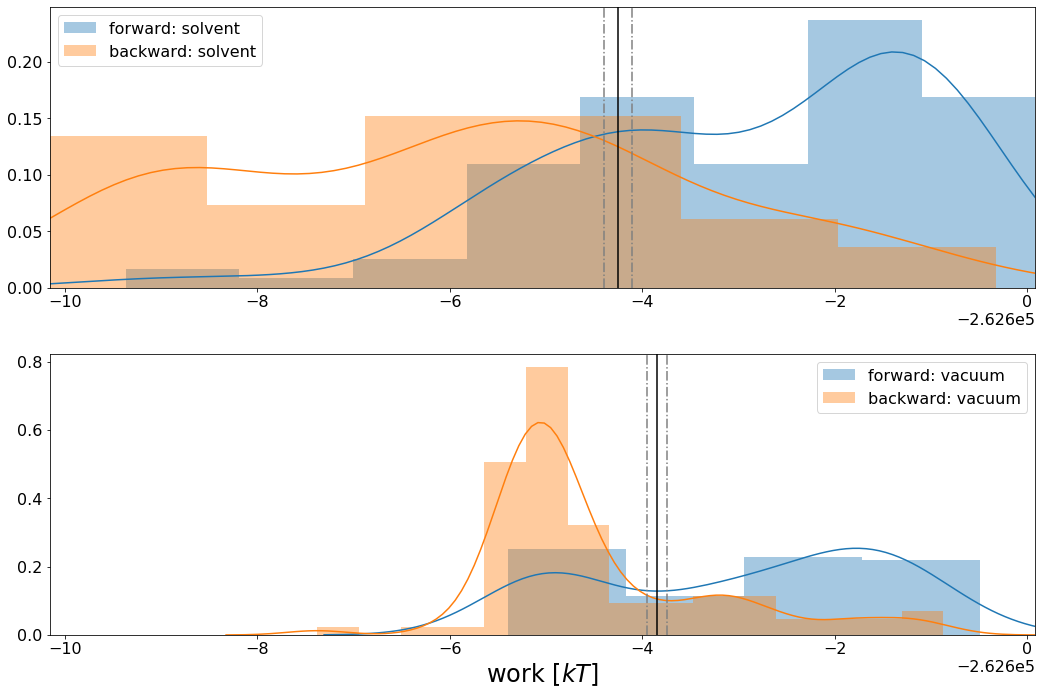

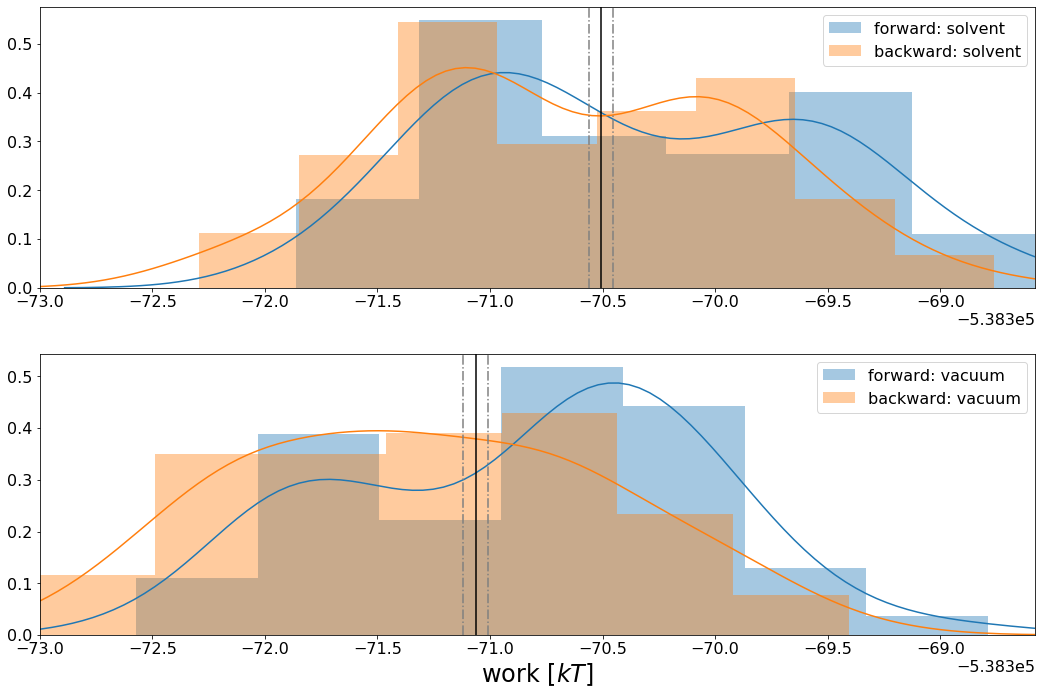

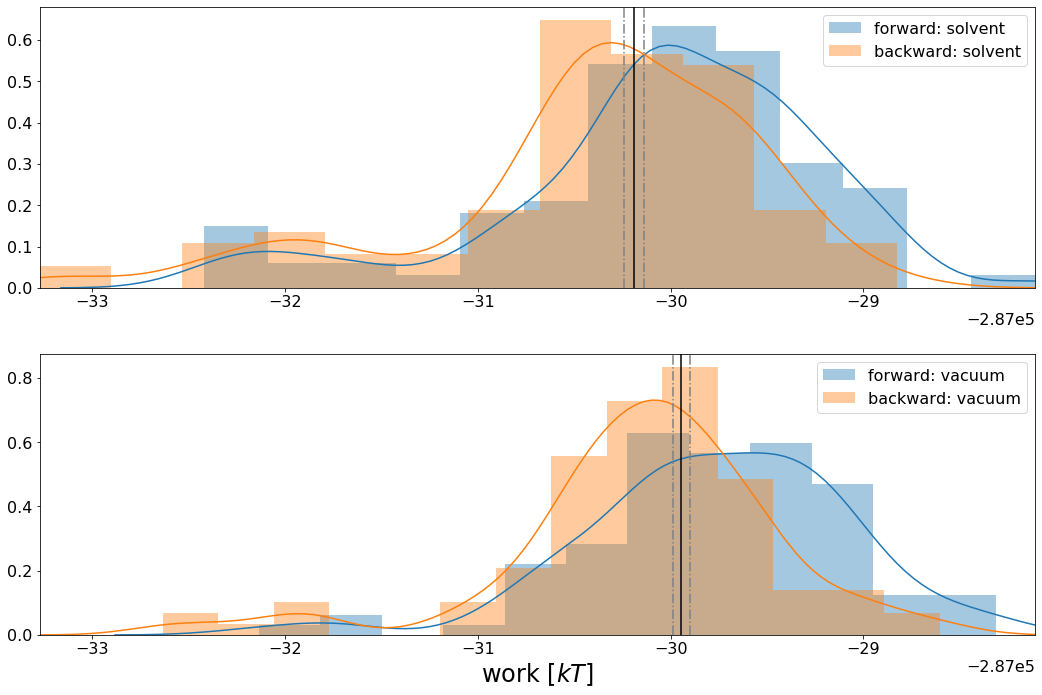

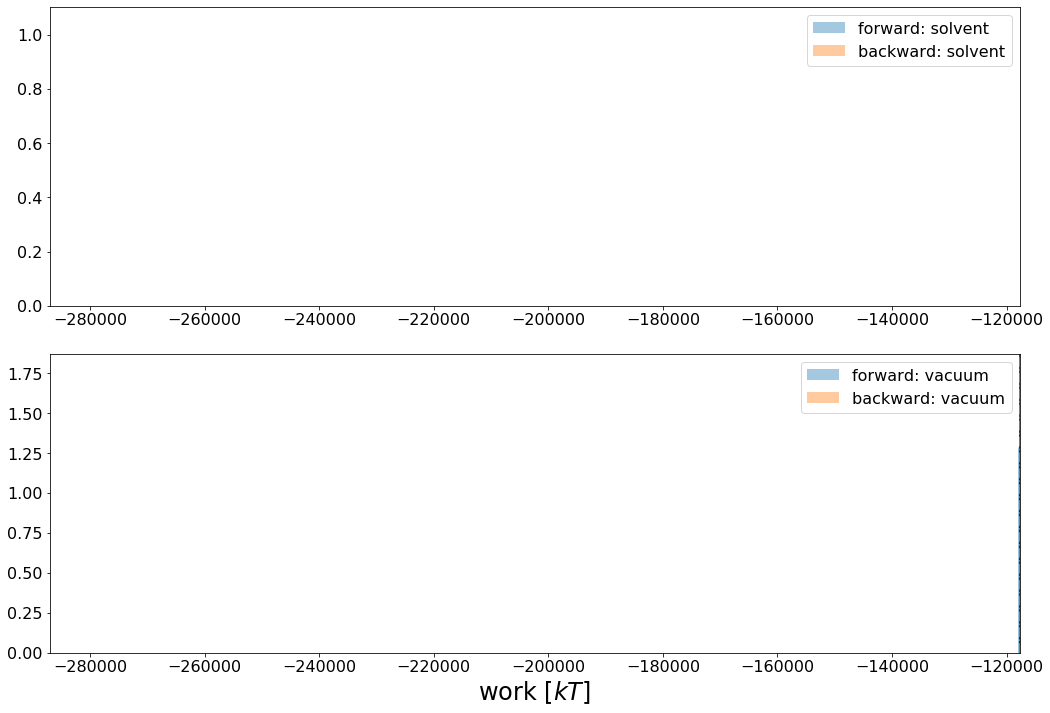

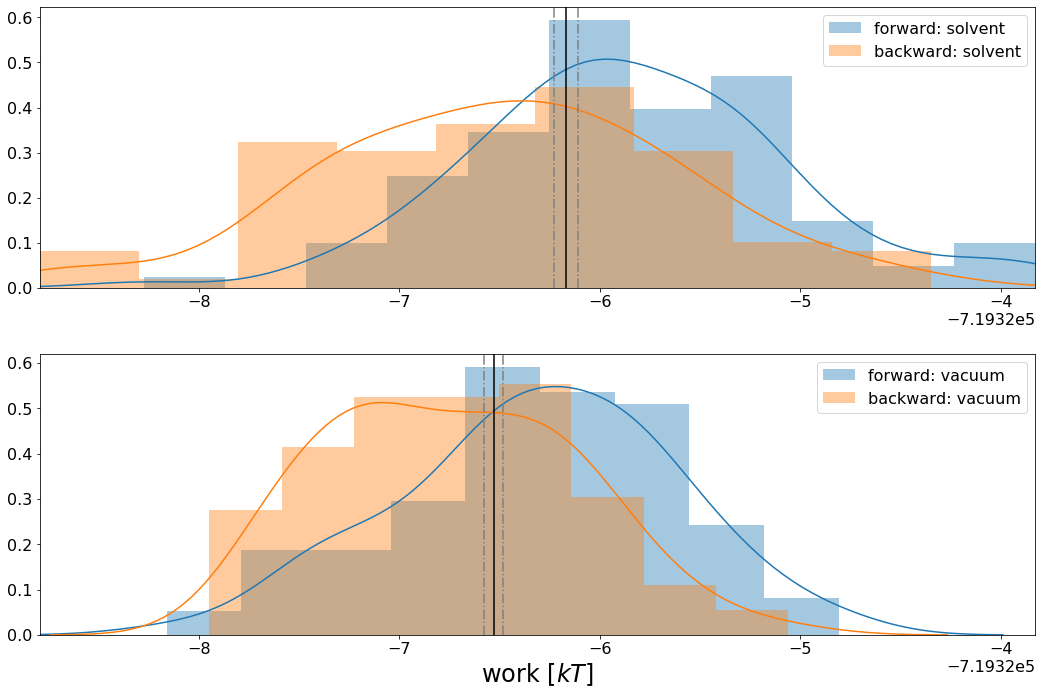

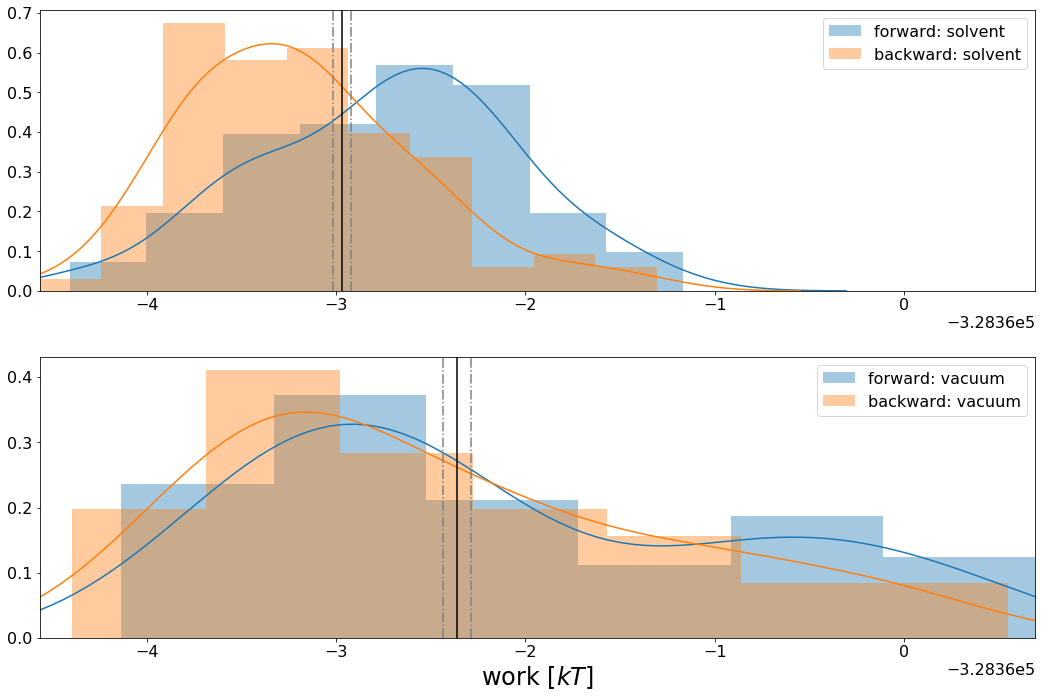

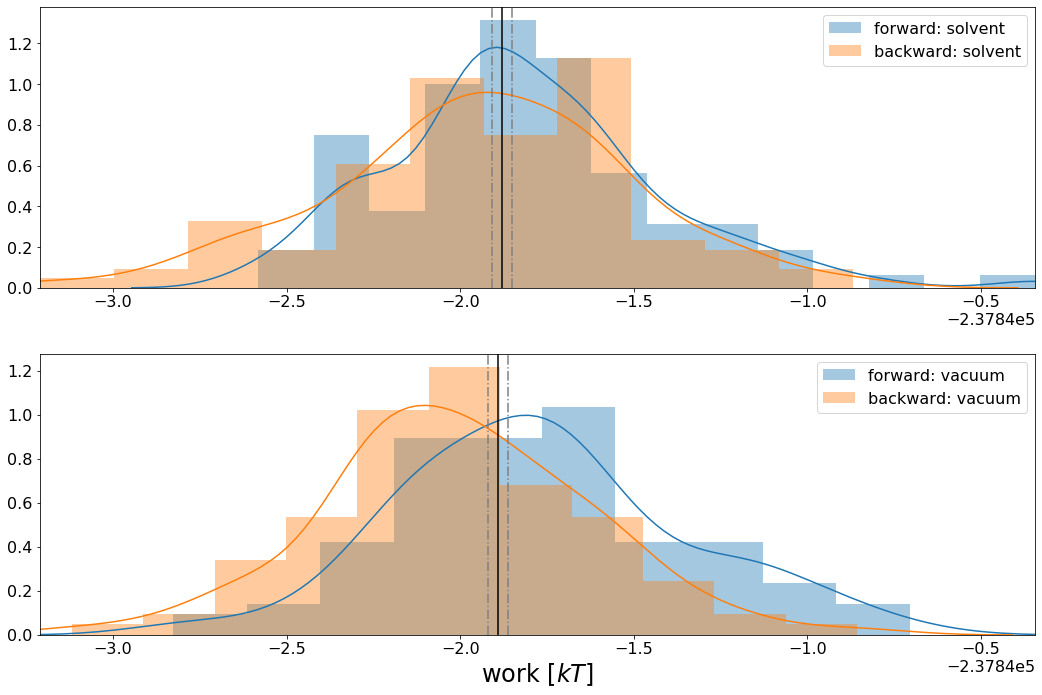

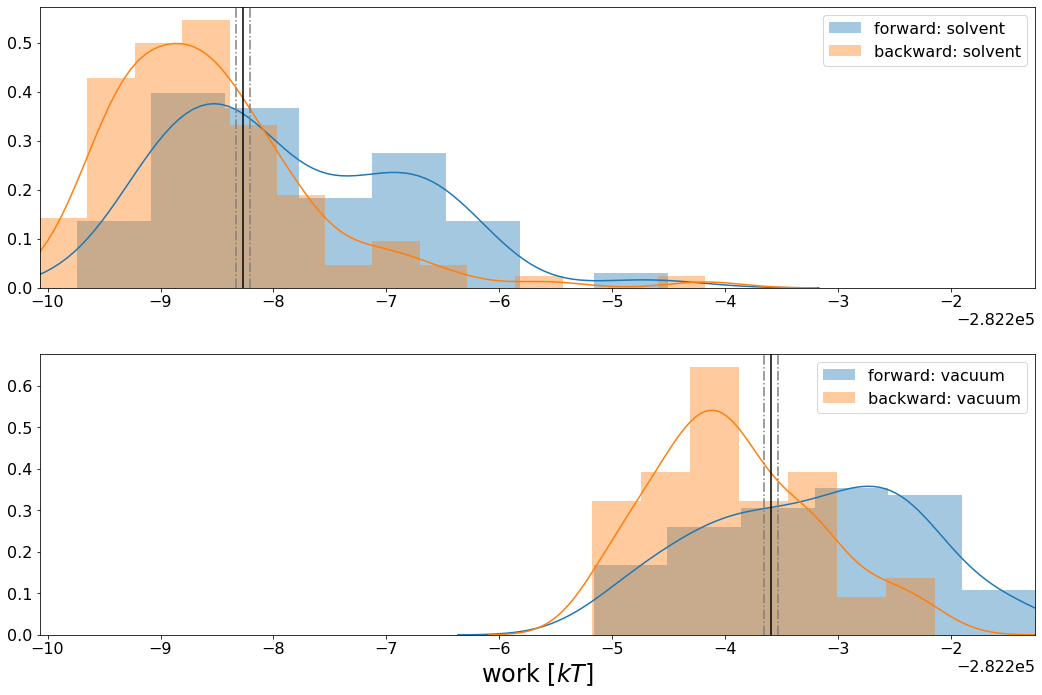

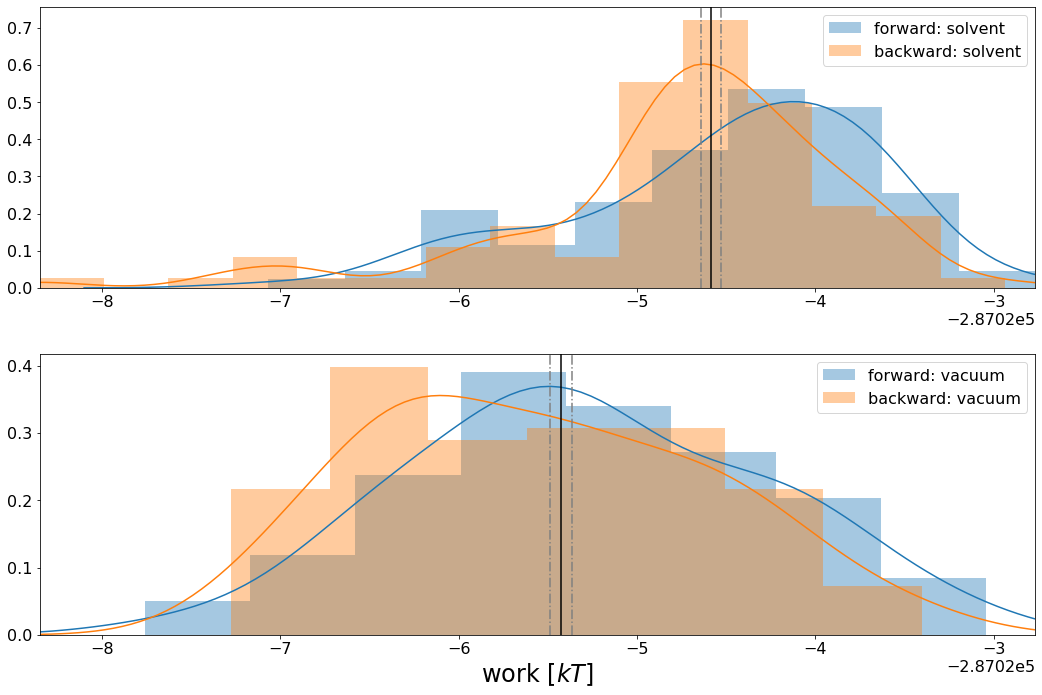

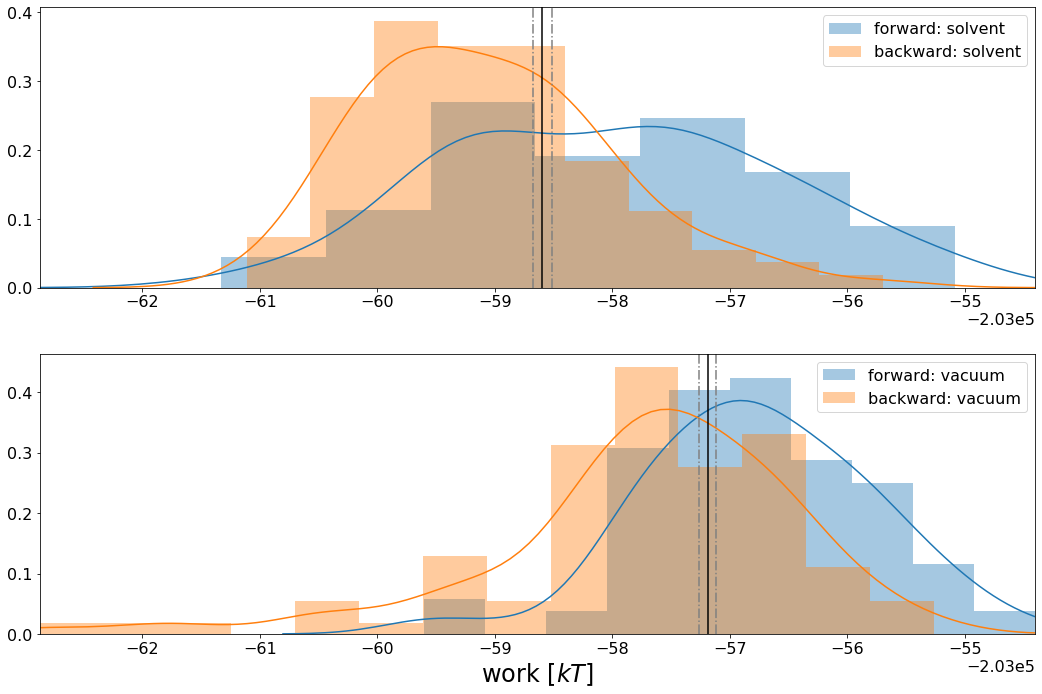

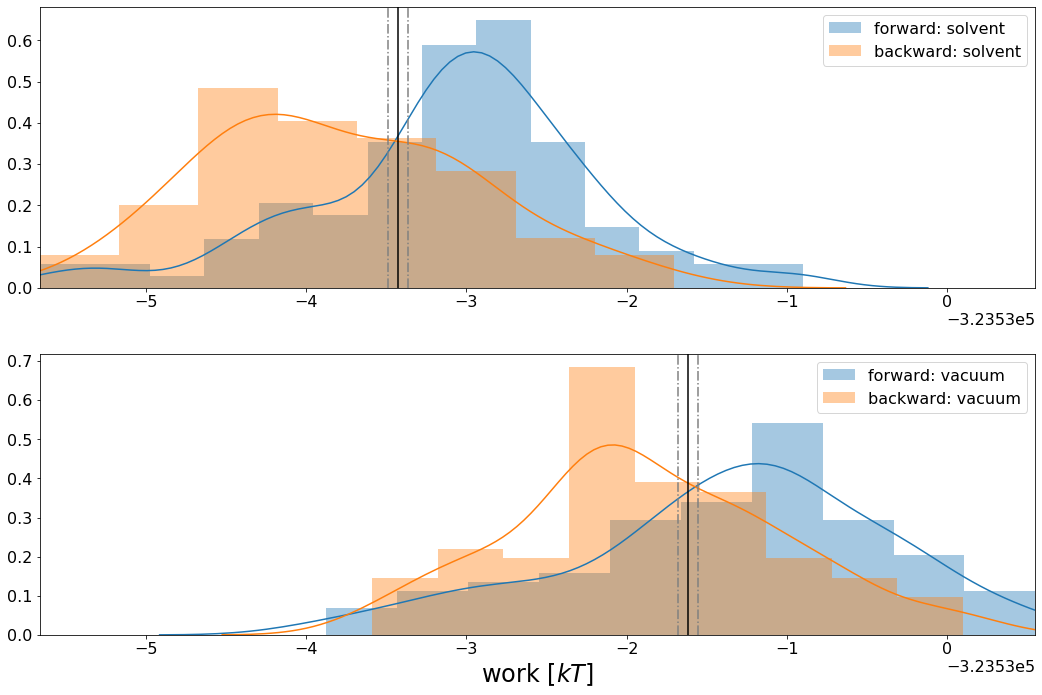

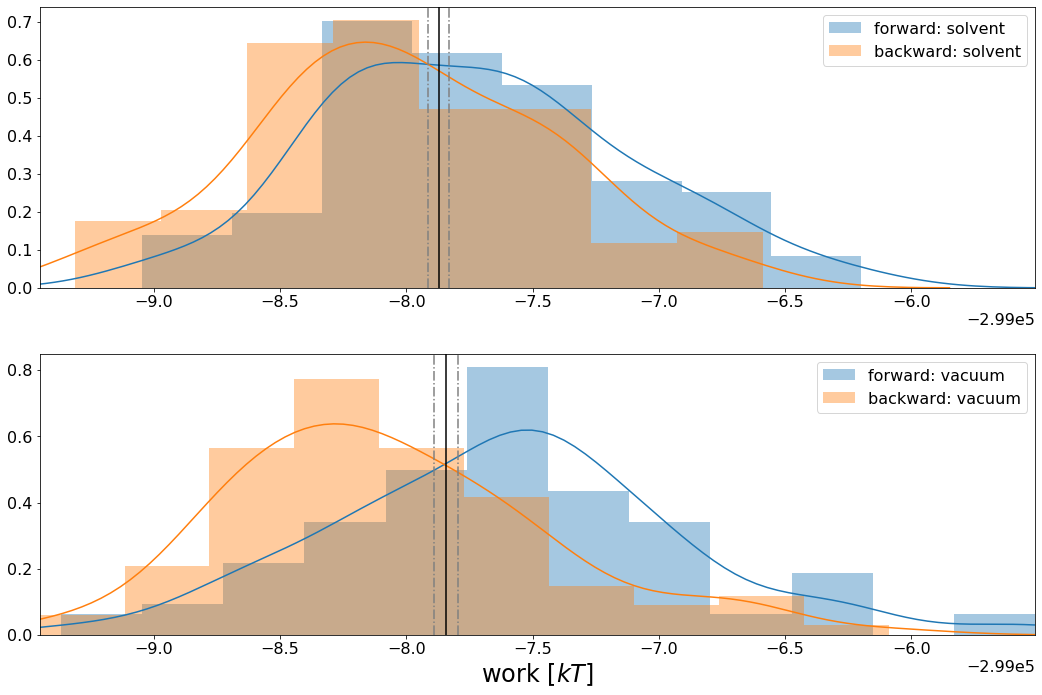

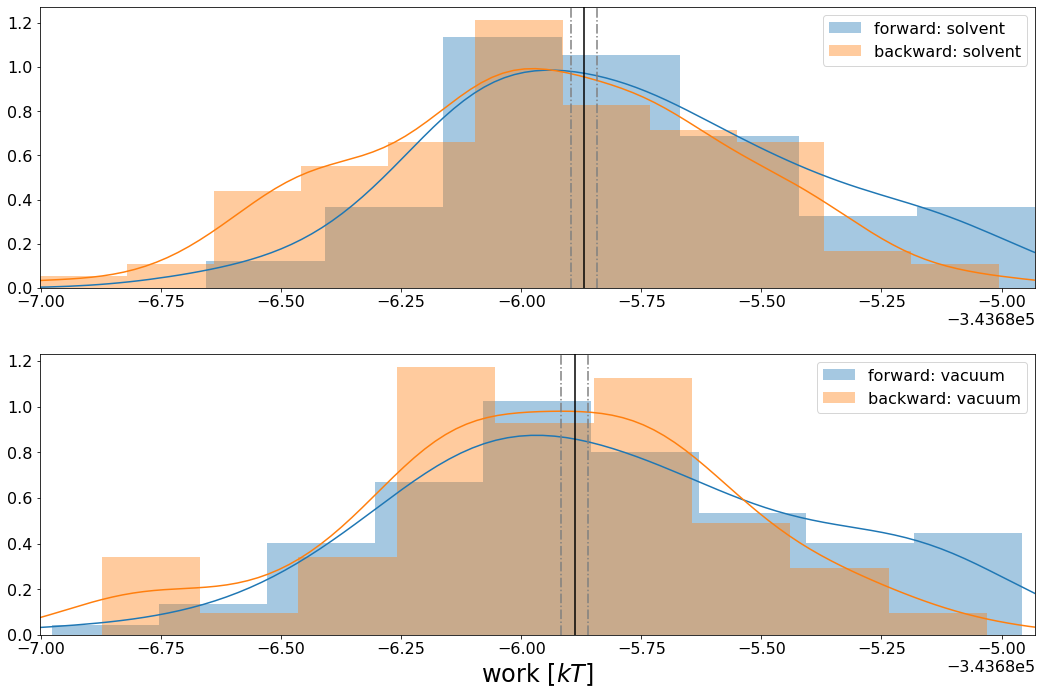

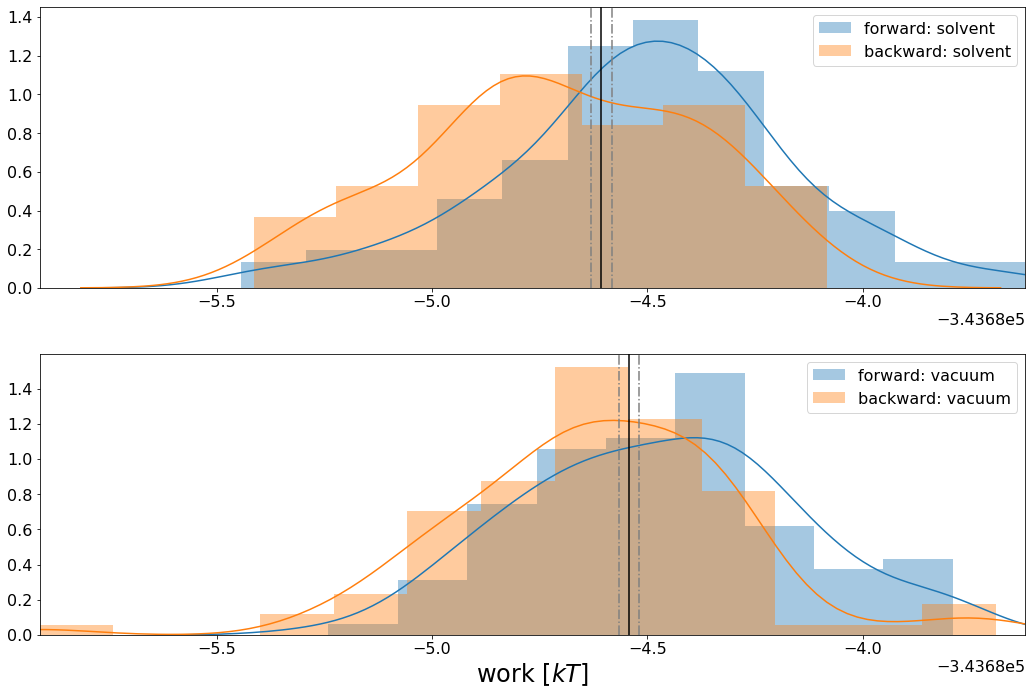

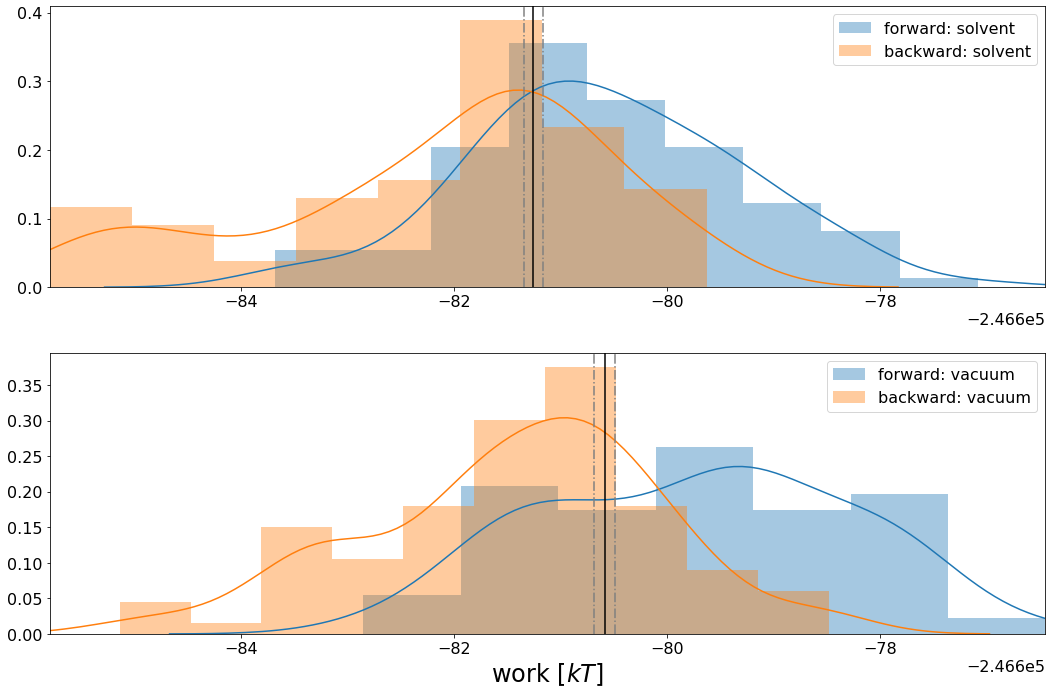

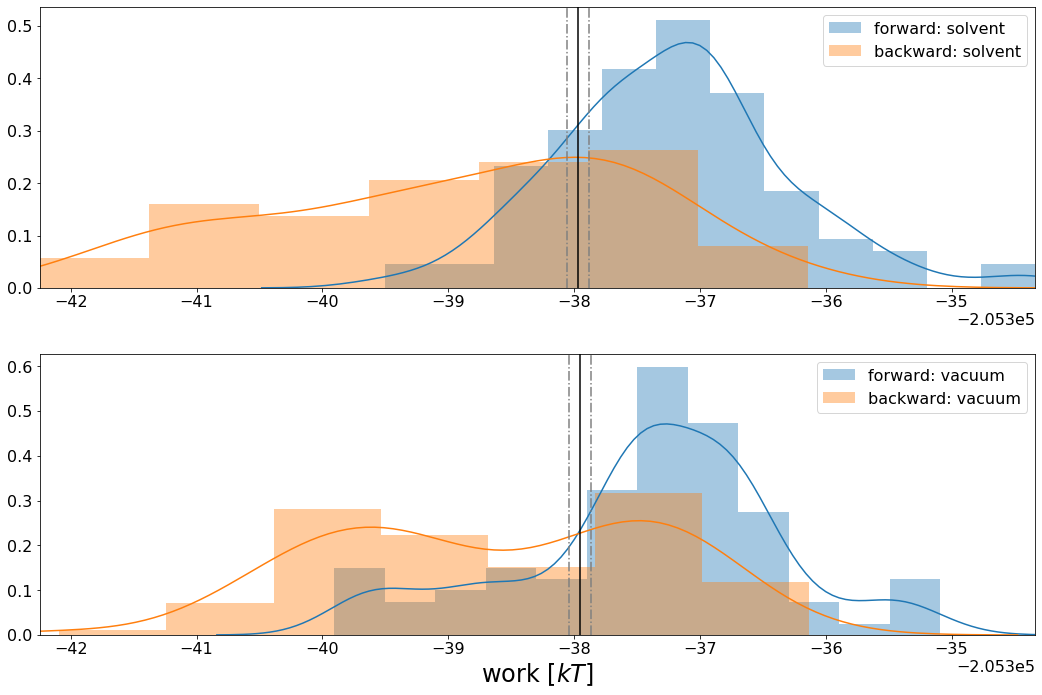

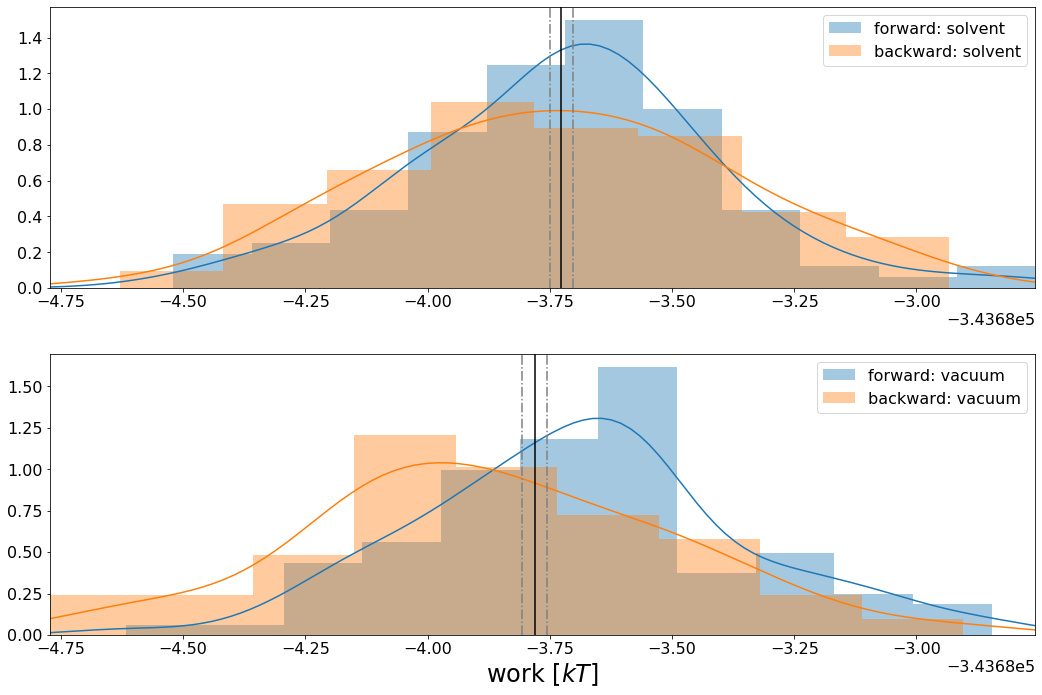

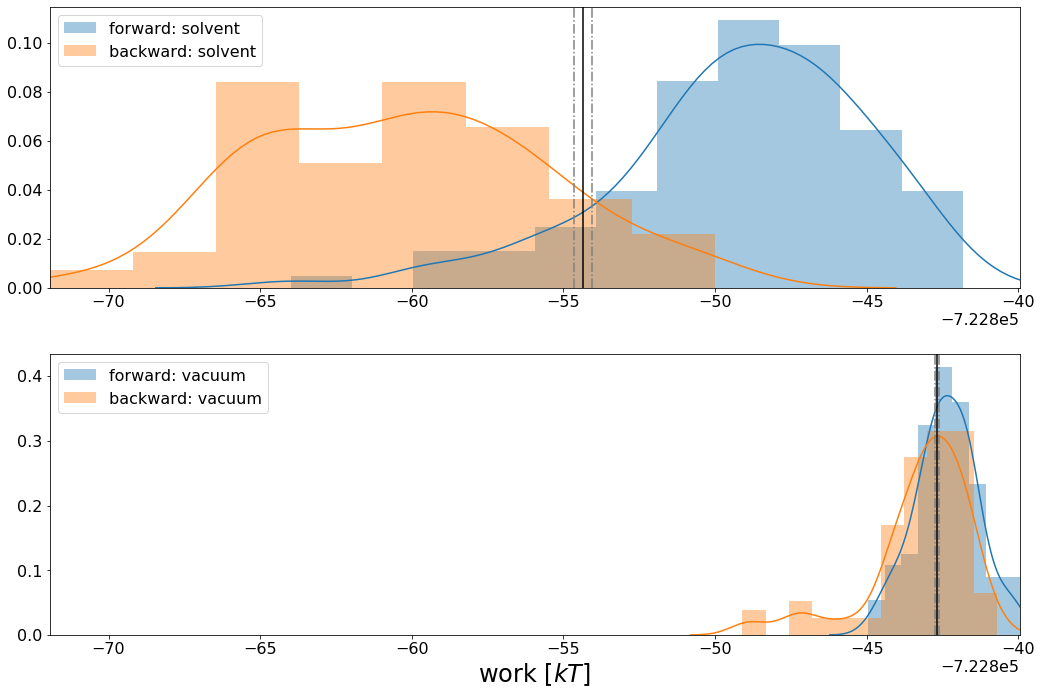

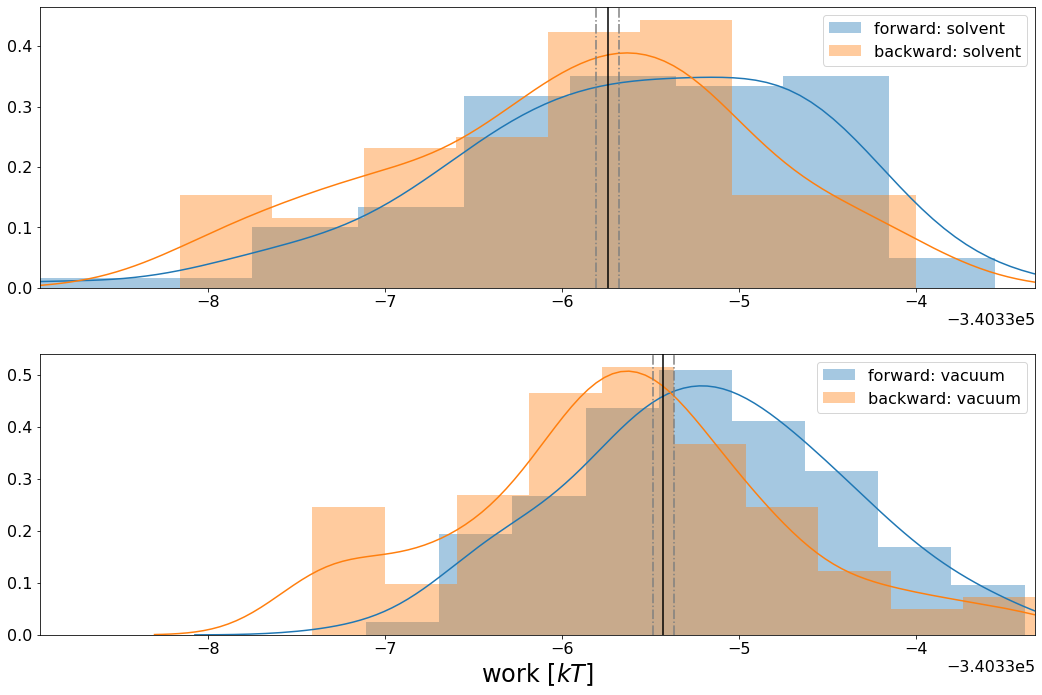

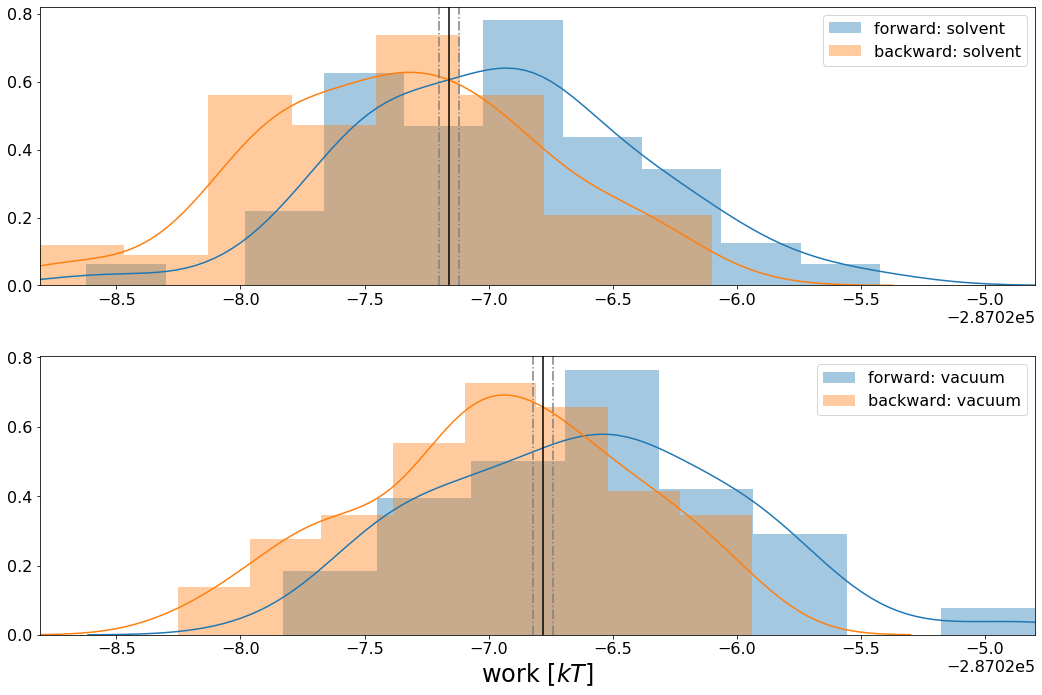

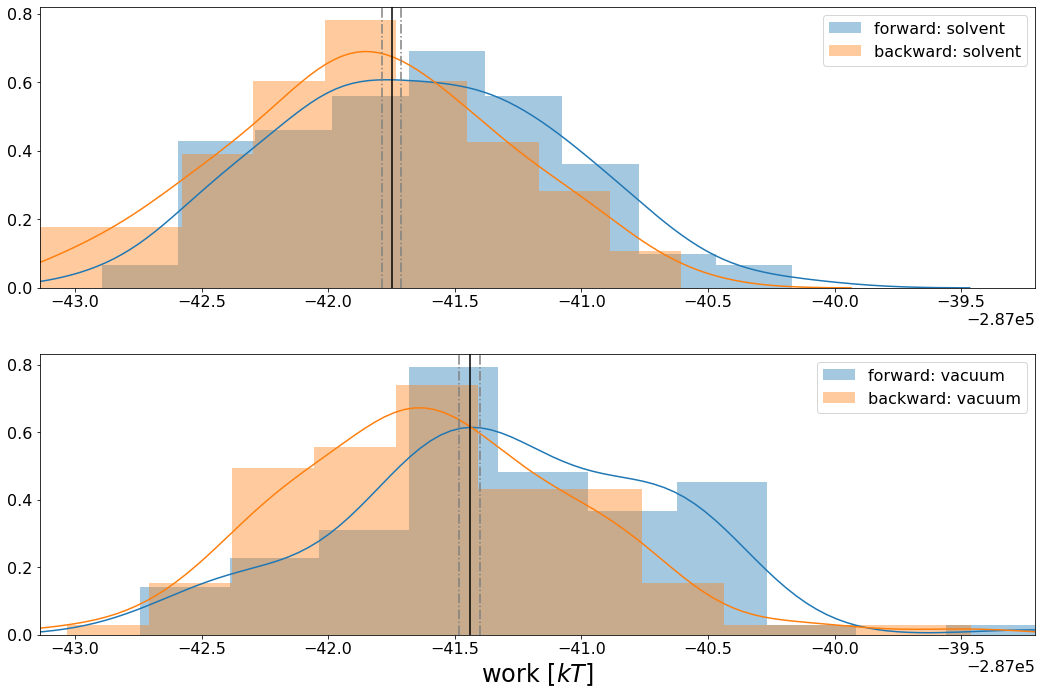

In [25]:
free_energy_corrections = {}
for lig_idx in range(64):
    interim_dict = {}
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    try:
        solvent_forward = np.array([val[-1] for val in work_dict[lig_idx]['solvent']['forward'].values()])
        sns.distplot(solvent_forward, color = default_color_cycle[0], ax=ax[0], label = f"forward: solvent")
    except Exception  as e:
        print(e)
    
    try:
        solvent_backward = np.array([val[-1] for val in work_dict[lig_idx]['solvent']['backward'].values()])
        sns.distplot(-solvent_backward, color = default_color_cycle[1], ax=ax[0], label = f"backward: solvent")
    except Exception as e:
        print(e)
    
    try:
        vacuum_forward = np.array([val[-1] for val in work_dict[lig_idx]['vacuum']['forward'].values()])
        sns.distplot(vacuum_forward, color = default_color_cycle[0], ax=ax[1], label = f"forward: vacuum")
    except Exception as e:
        print(e)
    
    try:
        vacuum_backward = np.array([val[-1] for val in work_dict[lig_idx]['vacuum']['backward'].values()])
        sns.distplot(-vacuum_backward, color = default_color_cycle[1], ax=ax[1], label = f"backward: vacuum")
    except Exception as e:
        print(e)
    
    try: #compute dg, ddg
        dg_vac, ddg_vac = BAR(vacuum_forward, vacuum_backward)
        ax[1].axvline(dg_vac, color='k')
        ax[1].axvline(dg_vac + ddg_vac, color='gray', ls = '-.')
        ax[1].axvline(dg_vac - ddg_vac, color='gray', ls = '-.')
        interim_dict['vacuum'] = (dg_vac, ddg_vac)
    except Exception as e:
        print(e)
    
    try: #compute dg, ddg
        dg_sol, ddg_sol = BAR(solvent_forward, solvent_backward)
        ax[0].axvline(dg_sol, color='k')
        ax[0].axvline(dg_sol + ddg_sol, color='gray', ls = '-.')
        ax[0].axvline(dg_sol - ddg_sol, color='gray', ls = '-.')
        interim_dict['solvent'] = (dg_sol, ddg_sol)
    except Exception as e:
        print(e)
    
    #can we make the x axes the same for both of these plots?
    try:
        min_plot0, max_plot0 = min([min(solvent_forward), min(-solvent_backward)]), max([max(solvent_forward), max(-solvent_backward)])
    except Exception as e:
        print(e)
    try:
        min_plot1, max_plot1 = min([min(vacuum_forward), min(-vacuum_backward)]), max([max(vacuum_forward), max(-vacuum_backward)])
    except Exception as e:
        print(e)
    
    try:
        min_plt = min([min_plot0, min_plot1])
        max_plt = max([max_plot0, max_plot1])
        ax[0].set_xlim(min_plt, max_plt)
        ax[1].set_xlim(min_plt, max_plt)
    except Exception as e:
        print(e)
    
    #clean up the plots
    plt.tight_layout()
    ax[1].set_xlabel(f"work [$kT$]")
    ax[0].legend()
    ax[1].legend()
    
    fig.savefig(f"lig{format(lig_idx, '02')}_workdist.png")
    free_energy_corrections[lig_idx] = interim_dict
    
    
    
        
    
    
    

ok, this looks relatively consistent. let's look at the dictionary of free energy corrections:

In [30]:
free_energy_corrections

{0: {'vacuum': (-245693.4457853754, 0.04149418210711547),
  'solvent': (-245693.31395404553, 0.04022313292619787)},
 1: {'vacuum': (-442438.64942960127, 0.05251437442575217),
  'solvent': (-442438.6827535505, 0.045488635839724956)},
 2: {'vacuum': (-343682.83868901455, 0.02864264084817191),
  'solvent': (-343682.86129864655, 0.030441654510072302)},
 3: {'vacuum': (-302350.6662953108, 0.023153028113107765),
  'solvent': (-302350.68640670035, 0.024557527175507295)},
 4: {'vacuum': (-121702.87633043318, 0.021194590581816906)},
 5: {'vacuum': (-643999.7127197409, 0.034247239822630476),
  'solvent': (-643999.8002518653, 0.034403243271388544)},
 6: {'vacuum': (-423819.47022160713, 0.034497667124356805),
  'solvent': (-423819.3884082166, 0.03750470187497489)},
 7: {'vacuum': (-405937.78871972143, 0.050435722771966736),
  'solvent': (-405939.1373120726, 0.08219282505588088)},
 8: {'vacuum': (-602368.0412652517, 0.0405223880611434),
  'solvent': (-602373.9192607901, 0.20630803237082623)},
 9: {

ok cool. now let's load and plot the freesolv dataset to figure out how to compare these

In [78]:
np.savez(f"ani_free_energy_corrections_kT.npz", free_energy_corrections)

In [31]:
freesolv = np.load(f"freesolv_dataset.npy")

In [39]:
freesolv

array([['-3.23', '-4.72', '0.03', '0.6', ' CCCCO'],
       ['-5.44', '-3.82', '0.03', '0.6', ' c1ccc(cc1)OC=O'],
       ['-2.87', '-4.84', '0.03', '0.6', ' Cc1cc(cnc1)C'],
       ['-3.34', '-4.93', '0.03', '0.6', ' Cc1ccncc1'],
       ['-3.49', '-5.1', '0.02', '0.6', ' CO'],
       ['-4.9', '-3.15', '0.02', '0.1', ' c1ccc2c(c1)Oc3ccccc3O2'],
       ['-8.16', '-5.88', '0.03', '0.6', ' Cc1c[nH]c2c1cccc2'],
       ['-5.28', '-6.79', '0.03', '0.6', ' c1ccc(cc1)CCO'],
       ['-14.15', '-20.52', '0.08', '0.27',
        ' C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O'],
       ['-3.15', '-4.62', '0.03', '0.6', ' CC[C@H](C)O'],
       ['-2.08', '-4.02', '0.02', '0.6', ' C[N+](=O)[O-]'],
       ['-8.28', '-10.0', '0.02', '0.6', ' CC(=O)NC'],
       ['-3.04', '-4.61', '0.03', '0.6', ' CC(=O)C1CC1'],
       ['-8.39', '-10.17', '0.03', '0.6', ' c1cc(ccc1C#N)O'],
       ['-3.39', '-5.0', '0.02', '0.6', ' CCO'],
       ['-3.2', '-5.22', '0.03', '0.6', ' Cc1ccncc1C'],
       ['-15.25', '-11.85', '0.04', '0.

In [32]:
freesolv_calc_dg, freesolv_exp_dg = [], []
for entry in freesolv:
    exp_dg, exp_ddg = float(entry[1]), float(entry[3])
    calc_dg, calc_ddg = float(entry[0]), float(entry[2])
    freesolv_calc_dg.append([calc_dg, calc_ddg])
    freesolv_exp_dg.append([exp_dg, exp_ddg])
freesolv_calc_dg = np.array(freesolv_calc_dg)
freesolv_exp_dg = np.array(freesolv_exp_dg)

(-25, 5)

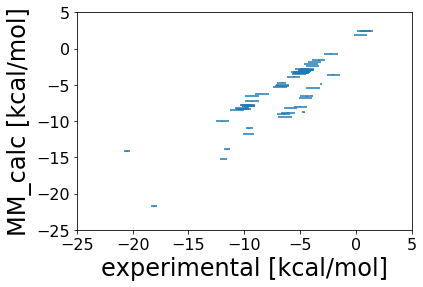

In [34]:
plt.errorbar(freesolv_exp_dg[:,0], freesolv_calc_dg[:,0], xerr = freesolv_exp_dg[:,1], yerr = freesolv_calc_dg[:,1], ls = 'None')
plt.xlabel(f"experimental [kcal/mol]")
plt.ylabel(f"MM_calc [kcal/mol]")
plt.xlim(-25, 5)
plt.ylim(-25, 5)

i need to be able to compare the residuals (w.r.t. experiment) of the MM (freesolv) calculations and the ANI-corrected freesolv calculations.
since the errors of the experimental data are relatively large, i think the best, most consistent thing to do would be to _only_ plot the residuals for which the uncertainty of the calculated dgs does not overlap with the uncertainty of the experimental dgs?

In [64]:
mm_residuals = abs((freesolv_calc_dg[:,0] - freesolv_exp_dg[:,0]))
freesolv_exp_dg_upper_lim = freesolv_exp_dg[:,0] + freesolv_exp_dg[:,1]
freesolv_exp_dg_lower_lim = freesolv_exp_dg[:,0] - freesolv_exp_dg[:,1]
mm_residuals_upper = (freesolv_calc_dg[:,0] - freesolv_exp_dg_upper_lim)**2
mm_residuals_lower = (freesolv_calc_dg[:,0] - freesolv_exp_dg_lower_lim)**2
max_mm_residuals = np.array([max([i,j]) for i,j in zip(mm_residuals_upper, mm_residuals_lower)])
min_mm_residuals = np.array([min([i,j]) for i,j in zip(mm_residuals_upper, mm_residuals_lower)])

498.55539999999996
229.40380000000007


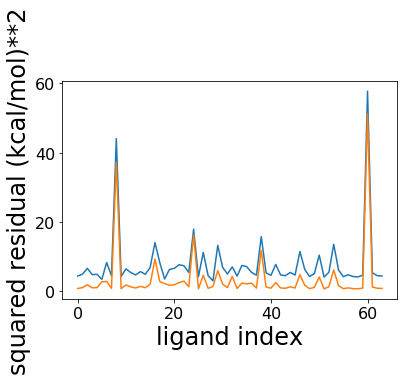

In [65]:
plt.plot(max_mm_residuals)
plt.plot(min_mm_residuals)
plt.xlabel(f"ligand index")
plt.ylabel(f"squared residual (kcal/mol)**2")
print(sum(max_mm_residuals))
print(sum(min_mm_residuals))

now, i should make ANI corrections to the free energies...

In [44]:
import copy
corrected_freesolv_calc_dg = copy.deepcopy(freesolv_calc_dg) #make a copy of freesolv data
for lig_idx in free_energy_corrections.keys():
    try:
        kcalmol_correction = (
                                (free_energy_corrections[lig_idx]['solvent'][0] - 
                                 free_energy_corrections[lig_idx]['vacuum'][0]) * 0.593 
                                + freesolv_calc_dg[lig_idx,0]
                                )
        error_correction = np.sqrt(
                                    (free_energy_corrections[lig_idx]['solvent'][1]*0.593)**2 
                                   + (free_energy_corrections[lig_idx]['vacuum'][1]*0.593)**2 
                                   + freesolv_calc_dg[lig_idx,1]**2
                                    )
        corrected_freesolv_calc_dg[lig_idx,0] = kcalmol_correction
        corrected_freesolv_calc_dg[lig_idx,1] = error_correction
    except Exception as e:
        print(e)


'solvent'
'solvent'


In [63]:
ani_residuals = abs((corrected_freesolv_calc_dg[:,0] - freesolv_exp_dg[:,0]))
ani_residuals_upper = abs((corrected_freesolv_calc_dg[:,0] - freesolv_exp_dg_upper_lim))
ani_residuals_lower = abs((corrected_freesolv_calc_dg[:,0] - freesolv_exp_dg_lower_lim))
max_ani_residuals = np.array([max([i,j]) for i,j in zip(ani_residuals_upper, ani_residuals_lower)])
min_ani_residuals = np.array([min([i,j]) for i,j in zip(ani_residuals_upper, ani_residuals_lower)])
print(sum(max_ani_residuals))
print(sum(min_ani_residuals))

158.24778781835155
89.13210799329771


AttributeError: module 'matplotlib.pyplot' has no attribute 'figsize'

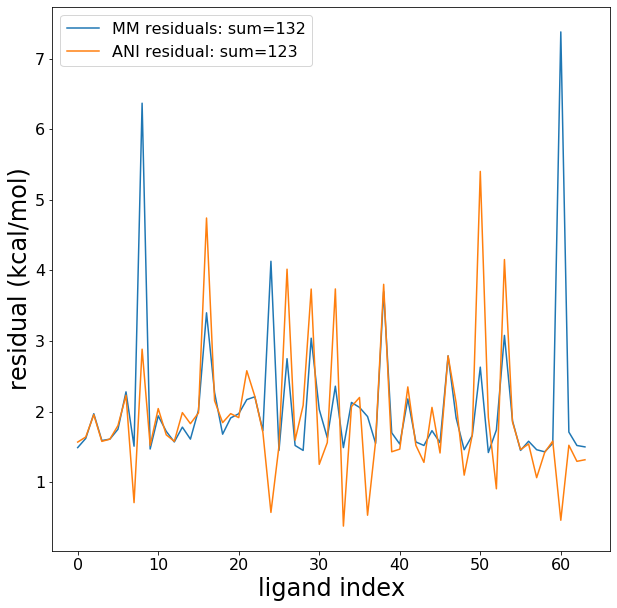

In [67]:
fig = plt.figure(figsize=(10, 10))
ani_sum_square_residuals = sum(ani_residuals)
mm_sum_square_residuals = sum(mm_residuals)
plt.plot(mm_residuals , label = f"MM residuals: sum={int(mm_sum_square_residuals)}")
plt.plot(ani_residuals, label = f"ANI residual: sum={int(ani_sum_square_residuals)}")
plt.xlabel(f"ligand index")
plt.ylabel(f"residual (kcal/mol)")
plt.legend()
plt.figsize(20, 20)

Text(0.5, 0, 'abs residual [kcal/mol]')

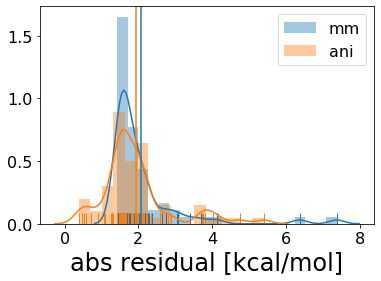

In [77]:
sns.distplot(mm_residuals, label = f"mm", rug=True)
sns.distplot(ani_residuals, label = f"ani", rug=True)
plt.axvline(np.mean(mm_residuals), color= default_color_cycle[0])
plt.axvline(np.mean(ani_residuals), color = default_color_cycle[1])
plt.legend()
plt.xlabel(f"abs residual [kcal/mol]")

0.3778399125269498